# Heart Failure ICU Prediction

Data from https://physionet.org/content/mimiciii-demo/1.4/ curated in https://www.kaggle.com/saurabhshahane/in-hospital-mortality-prediction

# Findings

The results across all experiments can be found below. Overall, the different models produced similar results in terms of ROC-AUC.  The probability of being correct is roughly 75%-79% depending on the selected model.    The hyperparameter tuning led to models being overfit with the training errors equal to 1.0 for the XGBoost and Multi-Layer Perceptron.  This illustrates the important of evaluating a model based on data it has not seen previously. 

In [239]:
results_dict

{'logistic_regression_training': 0.8624762583095916,
 'logistic_regression_validation': 0.7078125,
 'logistic_regression_test': 0.7793726741095162,
 'random_forest_training': 1.0,
 'random_forest_validation': 0.7474330357142858,
 'random_forest_test': 0.7856636540847066,
 'xgboost_training': 1.0,
 'xgboost_validation': 0.7430803571428571,
 'xgboost_test': 0.736842105263158,
 'logistic_regression_SMOTE_training': 0.8402629392212726,
 'logistic_regression_SMOTE_validation': 0.7421875,
 'logistic_regression_SMOTE_test': 0.7882332092858408,
 'random_forest_SMOTE_training': 1.0,
 'random_forest_SMOTE_validation': 0.7727678571428571,
 'random_forest_SMOTE_test': 0.7799043062200957,
 'xgboost_SMOTE_training': 1.0,
 'xgboost_SMOTE_validation': 0.79375,
 'xgboost_SMOTE_test': 0.7738791423001949,
 'SVM_training': 0.9923136277302944,
 'SVM_validation': 0.7620535714285714,
 'SVM_test': 0.7449937976253767,
 'MLP_training': 1.0,
 'MLP_validation': 0.7350446428571429,
 'MLP_test': 0.7572213361687046,

## Imports 

In [149]:
from statsmodels.stats.proportion import proportions_ztest
import shap 

In [150]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost
import scipy
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from xgboost import plot_importance
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE 
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from scipy.stats import norm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [151]:
%matplotlib inline

# Store results

In [152]:
results_dict = {}

## Helper Functions

In [153]:
def evaluate_model(model, X, y):
    ''' 
    Evaluate model for validation or test set
    '''
    y_pred = model.predict(X)
    y_probabilities = model.predict_proba(X)[:,1]

    print(classification_report(y, y_pred))
#    plot_confusion_matrix(model, X, y)
#    plt.show()

    # plot normalized confusion matrix
    cm = confusion_matrix(y, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cmn, annot=True, fmt='.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    score = roc_auc_score(y, y_probabilities)
    print(f"ROC AUC Score is {score}")
    plot_roc_curve(model, X, y)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show() 
    return score 

In [154]:
def impute_mean(df, feature): 
    '''
    for a data frame and continuous feature, impute missing value based on the mean 
    '''
    filtered_df = df[df.isna() == False]
    imputed_mean = filtered_df[feature].mean() 
    df[feature].fillna(imputed_mean,inplace=True)
    return df

In [155]:
# handle missing values 
def handle_missing_values(df, column): 
    '''A function that is able to impute values for missing data from column mean
    Handles cases where null or where value = ?
    '''
    subset_df = df[column][(df[column] != '?') & (df[column].isna() == False)]
    imputed_mean = subset_df.astype(str).astype(int).mean()
    for row in range(0,len(df[column])):
        if (df[column].iloc[row] == '?') | (df[column].iloc[row] != df[column].iloc[row]):
            df.at[row,column] = imputed_mean 
        else: 
            pass
    return df

In [156]:
def z_standardize_variable(train_df, test_df, val_df, column, drop_original):
    ''' Given an entiner data set, perform a z standardizisation for a given column.
    z = value - mean / standard deviation
    '''
    
    # calculate mean and variance from training set
    mean_val = train_df[column].mean()
    std_dev_val = train_df[column].std()

    # create a dummy field in df
    train_df[column+'_standardized'] = 0.0
    test_df[column+'_standardized'] = 0.0
    val_df[column+'_standardized'] = 0.0
    
    # create new variable for training set
    for index in range(0,len(train_df[column])):
        train_df.at[index, column+'_standardized'] = (train_df.at[index, column] - mean_val) / std_dev_val
    
    if drop_original == 'drop':
        train_df = train_df.drop(columns = column)
    else: 
        pass
    
    # standardize test 
    for j_index in range(0,len(test_df[column])):
        test_df.at[j_index, column+'_standardized'] = (test_df.at[j_index, column] - mean_val) / std_dev_val
    
    # drop original 
    if drop_original == 'drop':
        test_df = test_df.drop(columns = column)
    else: 
        pass
        
    # standardize validation 
    for k_index in range(0,len(val_df[column])):
        val_df.at[k_index, column+'_standardized'] = (val_df.at[k_index, column] - mean_val) / std_dev_val
        
    # drop original     
    if drop_original == 'drop':
        val_df = val_df.drop(columns = column)
    else: 
        pass

    return train_df, test_df, val_df 

In [157]:
def compare_features(df, response, feature, bins, save_fig):
    '''
    for a continuous feature, compare the distribution between the positive and negative classes 
    returns a plot and results of t-test for statistical significance
    '''
    # filter out nulls and filter on class 
    positive_class = df[df[response] ==1][feature]
    negative_class = df[df[response] ==0][feature]
    
    # filter out nulls
    positive_class = positive_class[positive_class.isna() == False]
    negative_class = negative_class[negative_class.isna() == False]

    # histogram 
    plt.subplots(tight_layout=True)
    plt.hist(positive_class, bins, alpha=0.5, label='positive_class')
    plt.hist(negative_class, bins, alpha=0.5, label='negative_class')
    plt.legend(loc='upper right')
    plt.title(f"Comparison of {feature} for {response}")

    if save_fig == 1: 
        plt.savefig(f'project/project-results/histogram-comparing-{feature}-by{response}',format = 'png')
    else: 
        pass 
    plt.show()
    
    # t test 
    results = ttest_ind(positive_class, negative_class)
    print(f"{feature}\n {results}")
    if results[1] < 0.05: 
        print("Difference is statistically significant at alpha = 0.05")
    else: 
        print("Result is not statistically significant at alpha = 0.05")

In [158]:
def compare_features_prop(df, response, feature, bins):
    '''
    for a discrete feature, compare the distribution between the positive and negative classes 
    returns a plot and results of prop test for statistical significance
    '''
    
    # filter out nulls and filter on class 
    positive_class = df[df[response] ==1][feature]
    negative_class = df[df[response] ==0][feature]
    
    # filter out nulls
    positive_class = positive_class[positive_class.isna() == False]
    negative_class = negative_class[negative_class.isna() == False]
    
    # calculate proportions for non null 
    positive_prop = sum(positive_class)/len(positive_class)
    negative_prop = sum(negative_class)/len(negative_class)

    # histogram 
    plt.hist(positive_class, bins, alpha=0.5, label='positive_class')
    plt.hist(negative_class, bins, alpha=0.5, label='negative_class')
    plt.legend(loc='upper right')
    plt.title(f"Comparison of {feature} for {response}")
    plt.show()
    
    # z test for proportions 
    prop_difference = positive_prop - negative_prop 
    prop_variance = (positive_prop*(1-positive_prop))/(len(positive_class)) + (negative_prop*(1-negative_prop))/(len(negative_class))
    z_critical = norm.ppf(0.975)
    interval = prop_variance**.5 * z_critical 
    z_value = prop_difference / prop_variance**.5
    confidence_interval = [prop_difference-interval, prop_difference+interval]
    
    
    
    print(f"Positive class proportion of {feature} is {positive_prop}")
    print(f"Negative class proportion of {feature} is {negative_prop}")
    print(f"Sample size for positive class {len(positive_class)}")
    print(f"Sample size for negative class {len(negative_class)}")
    print(f"Critical value is {z_value} compared to {z_critical}")
    if abs(z_value) > z_critical: 
        print("Difference is statistically significant at alpha = 0.05")
    else: 
        print("Result is not statistically significant at alpha = 0.05")

In [159]:
# handle categorical data 
def handle_categorical_data(df, column = str, category_type = str, ordinal_rank = dict, drop_original = str):
    '''A function that performs one-hot encoding for a given column and assigns ordinal ranking based on input 
    category_types are ordinal, nominal 
    Drops original feature for ordinal encoding
    '''
    if category_type == 'nominal':
        new_columns = df[column].unique() 
        for new_column in new_columns:
            new_column_name = column + '_' + new_column.lower() + '_indicator'
            df[new_column_name] = df[column] == new_column
            df[new_column_name] = df[new_column_name].replace({True:1,False:0})
        if drop_original == 'drop': 
            df = df.drop(columns = column)
        else: 
            pass

    elif category_type == 'ordinal':
        df[column + '_ordinal'] = df[column]
        for key in ordinal_rank: 
            df[column + '_ordinal'] = df[column + '_ordinal'].replace(key,ordinal_rank[key])
    else: 
        print("enter nominal or ordinal for cateogry type")
        pass 
    return df

# Read in Data

In [160]:
df = pd.read_csv("data01.csv")

## Inspect data frame

There are roughly 50 features in this data set. We need to look at the data to indentify features that may be predictive. We also want to understand the prevalence of missing data. 

In [161]:
df.head().T

,0,1,2,3,4
group,1.000000,1.000000,1.000000,1.000000,1.000000
ID,125047.000000,139812.000000,109787.000000,130587.000000,138290.000000
outcome,0.000000,0.000000,0.000000,0.000000,0.000000
age,72.000000,75.000000,83.000000,43.000000,75.000000
gendera,1.000000,2.000000,2.000000,2.000000,2.000000
BMI,37.588179,NaN,26.572634,83.264629,31.824842
hypertensive,0.000000,0.000000,0.000000,0.000000,1.000000
atrialfibrillation,0.000000,0.000000,0.000000,0.000000,0.000000
CHD with no MI,0.000000,0.000000,0.000000,0.000000,0.000000
diabetes,1.000000,0.000000,0.000000,0.000000,0.000000


### How many nulls?

In [162]:
df.shape

(1177, 51)

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

Upon inspection, we have the following fields with nulls: 
* BMI 
* outcome (1 null) 
* Neutrophils 
* basophils 
* Lympcyte 
* PT 
* INR 
* Creatine kinase 
* glucose 
* Blood Calcium (1 null) 
* PH 
* Lactic acid 
* PC02 
* EF

We need to decide how to handle each between discaring the records or imputing a value. 

<AxesSubplot:>

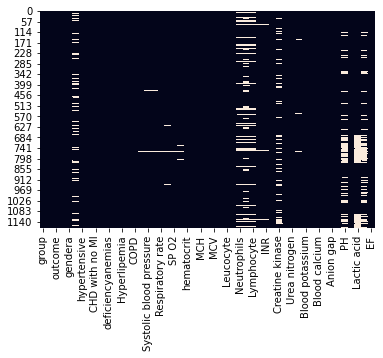

In [164]:
sns.heatmap(df.isnull(), cbar=False)

Upon visual inspection of the plot, it appears that some features are missing at random and some have patterns to their missingness that is not consistent with a uniform distribution.

# Filter out the single null value for Outcome 

Because the outcome class only has one instance of being null, we are safe to discard this observation.

In [165]:
df = df[df.outcome.isna() == False]

In [166]:
df.shape

(1176, 51)

# Class Balance

In [167]:
df.groupby(by='outcome').size()

outcome
0.0    1017
1.0     159
dtype: int64

In [168]:
159/(1017+159)*100 

13.520408163265307

The class is imbalanced with 13% of the observations being in the positive class. This ratio is roughly 1:8. 

# Comparison of features

For this analysis, we will filter based on alpha = 0.05 level of significance

In [169]:
continuous_features =    ['heart rate'
                         ,'Systolic blood pressure', 'Diastolic blood pressure'
                         ,'Respiratory rate', 'temperature', 'SP O2', 'Urine output'
                         , 'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte'
                         ,'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR'
                         ,'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen'
                         ,'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium'
                         ,'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate'
                         ,'Lactic acid', 'PCO2', 'EF']

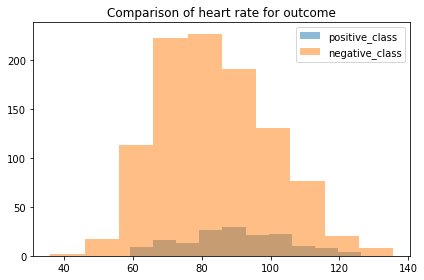

heart rate
 Ttest_indResult(statistic=4.460635913313653, pvalue=8.964104077003178e-06)
Difference is statistically significant at alpha = 0.05


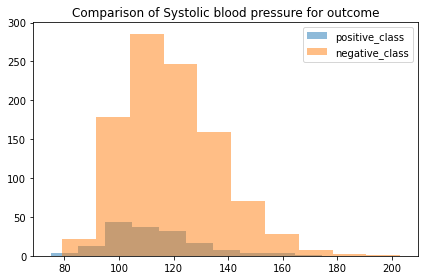

Systolic blood pressure
 Ttest_indResult(statistic=-4.563436091755674, pvalue=5.5681858198710216e-06)
Difference is statistically significant at alpha = 0.05


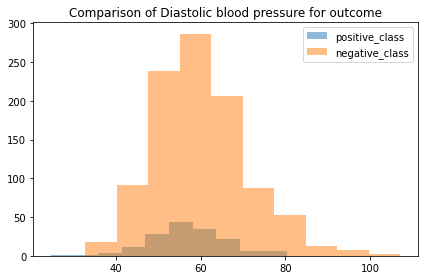

Diastolic blood pressure
 Ttest_indResult(statistic=-2.986973815380993, pvalue=0.0028767806898558645)
Difference is statistically significant at alpha = 0.05


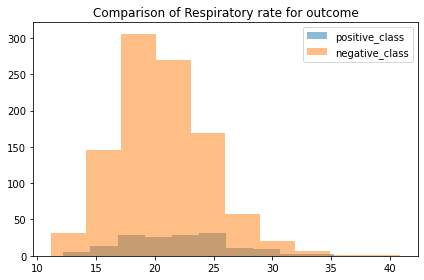

Respiratory rate
 Ttest_indResult(statistic=4.016412164137911, pvalue=6.28846420570941e-05)
Difference is statistically significant at alpha = 0.05


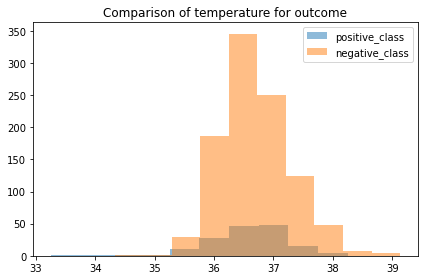

temperature
 Ttest_indResult(statistic=-3.170967494813875, pvalue=0.0015592681807617686)
Difference is statistically significant at alpha = 0.05


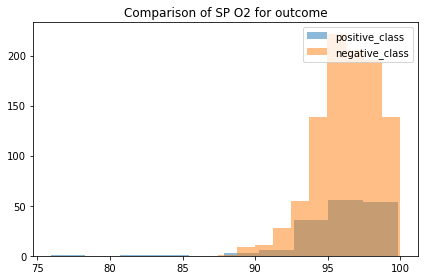

SP O2
 Ttest_indResult(statistic=-2.432881479361792, pvalue=0.015129285579919967)
Difference is statistically significant at alpha = 0.05


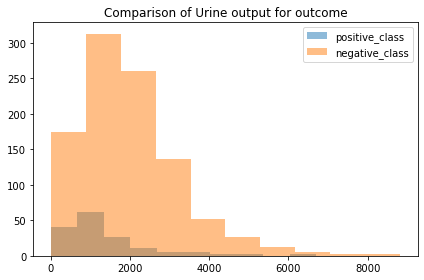

Urine output
 Ttest_indResult(statistic=-5.932753175864505, pvalue=3.9474092072787074e-09)
Difference is statistically significant at alpha = 0.05


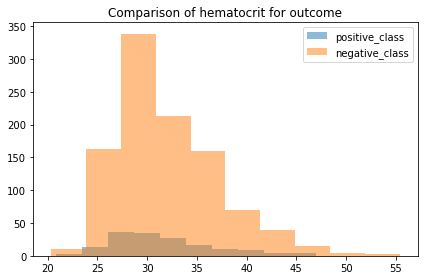

hematocrit
 Ttest_indResult(statistic=-0.5665525267234411, pvalue=0.5711265261910976)
Result is not statistically significant at alpha = 0.05


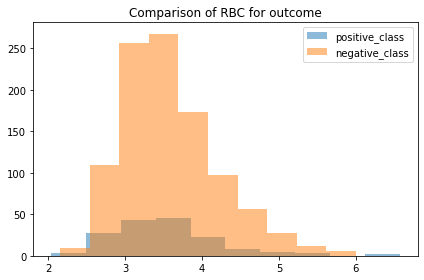

RBC
 Ttest_indResult(statistic=-0.8223054280628849, pvalue=0.41107006486271)
Result is not statistically significant at alpha = 0.05


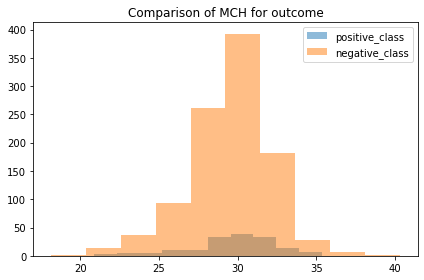

MCH
 Ttest_indResult(statistic=0.4587242950569747, pvalue=0.6465170741828828)
Result is not statistically significant at alpha = 0.05


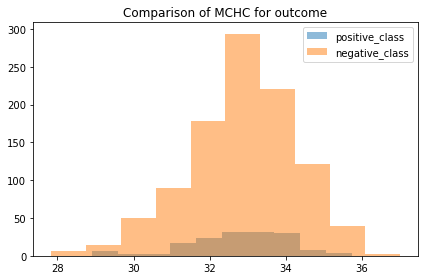

MCHC
 Ttest_indResult(statistic=-1.0930633879895293, pvalue=0.27459020671004614)
Result is not statistically significant at alpha = 0.05


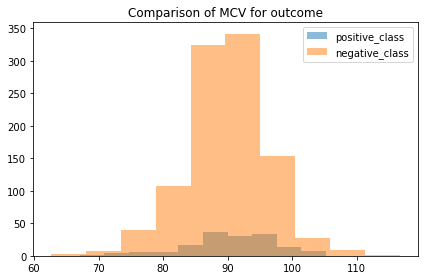

MCV
 Ttest_indResult(statistic=1.170574692707898, pvalue=0.24200732742661984)
Result is not statistically significant at alpha = 0.05


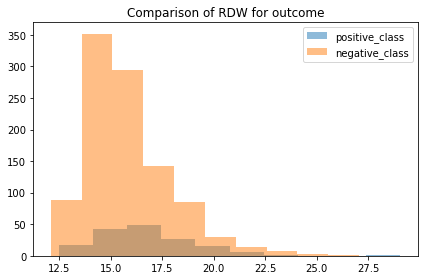

RDW
 Ttest_indResult(statistic=5.13064527726537, pvalue=3.3760464774189586e-07)
Difference is statistically significant at alpha = 0.05


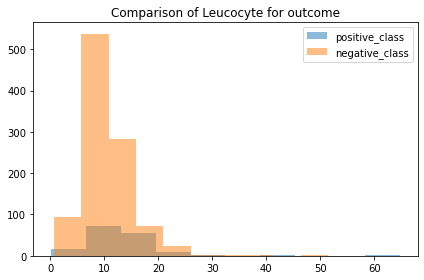

Leucocyte
 Ttest_indResult(statistic=7.296224666292146, pvalue=5.435014441016425e-13)
Difference is statistically significant at alpha = 0.05


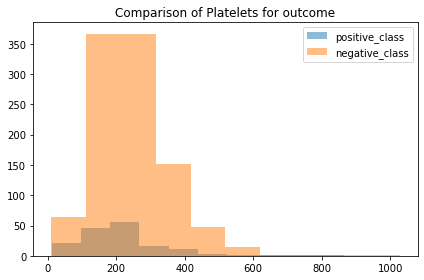

Platelets
 Ttest_indResult(statistic=-3.043081350076029, pvalue=0.0023937406106352204)
Difference is statistically significant at alpha = 0.05


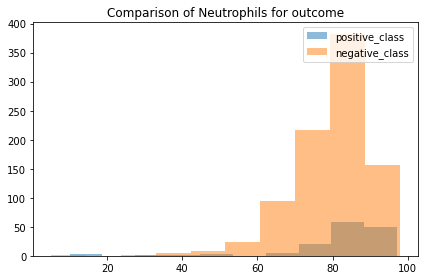

Neutrophils
 Ttest_indResult(statistic=2.3224691224734886, pvalue=0.020401841781639105)
Difference is statistically significant at alpha = 0.05


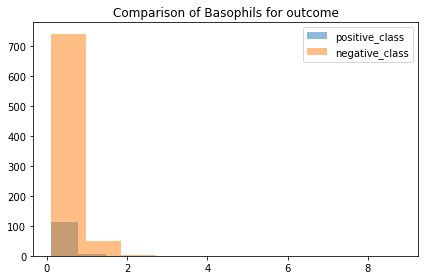

Basophils
 Ttest_indResult(statistic=-0.7966934516224082, pvalue=0.4258357527131428)
Result is not statistically significant at alpha = 0.05


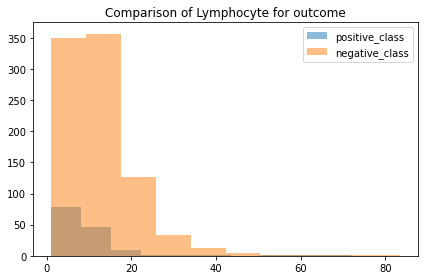

Lymphocyte
 Ttest_indResult(statistic=-4.500450821979715, pvalue=7.553927329611614e-06)
Difference is statistically significant at alpha = 0.05


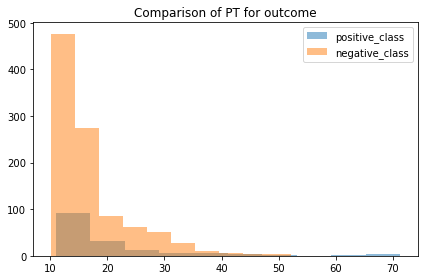

PT
 Ttest_indResult(statistic=4.813666113036415, pvalue=1.6784347802716823e-06)
Difference is statistically significant at alpha = 0.05


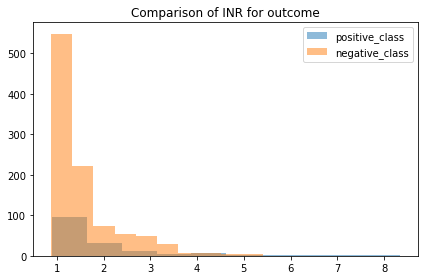

INR
 Ttest_indResult(statistic=4.958842322239112, pvalue=8.15338226202114e-07)
Difference is statistically significant at alpha = 0.05


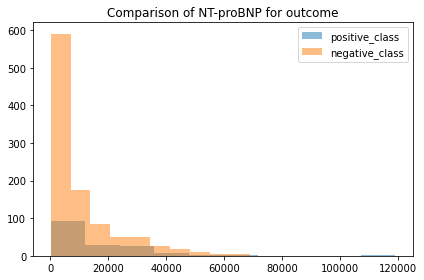

NT-proBNP
 Ttest_indResult(statistic=4.179227671954513, pvalue=3.142002997069749e-05)
Difference is statistically significant at alpha = 0.05


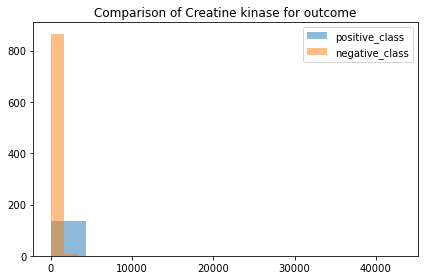

Creatine kinase
 Ttest_indResult(statistic=2.4421557476924427, pvalue=0.014770629937342131)
Difference is statistically significant at alpha = 0.05


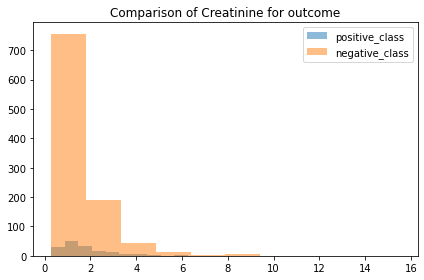

Creatinine
 Ttest_indResult(statistic=1.6024390573270988, pvalue=0.10932755472570051)
Result is not statistically significant at alpha = 0.05


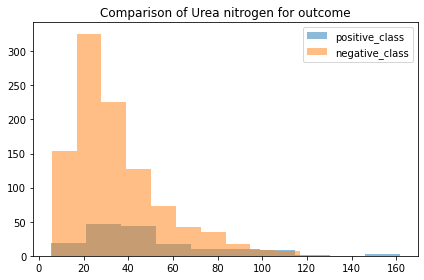

Urea nitrogen
 Ttest_indResult(statistic=7.10430009803924, pvalue=2.0924178911735475e-12)
Difference is statistically significant at alpha = 0.05


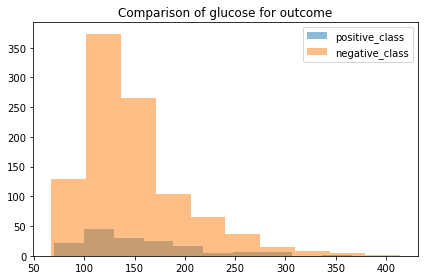

glucose
 Ttest_indResult(statistic=1.1038906758111962, pvalue=0.2698700930751589)
Result is not statistically significant at alpha = 0.05


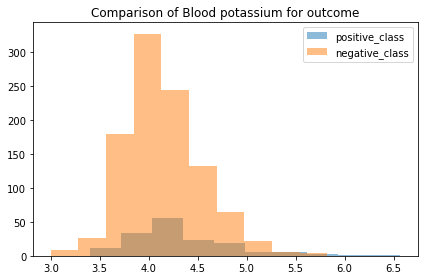

Blood potassium
 Ttest_indResult(statistic=4.736685359053484, pvalue=2.4375623655623248e-06)
Difference is statistically significant at alpha = 0.05


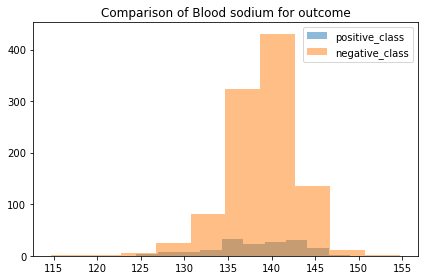

Blood sodium
 Ttest_indResult(statistic=-2.278967234192661, pvalue=0.02284791147635487)
Difference is statistically significant at alpha = 0.05


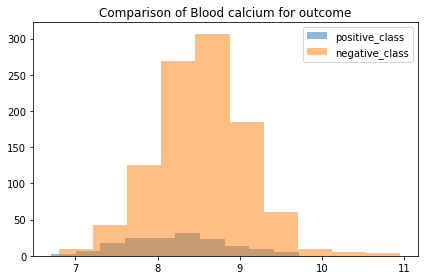

Blood calcium
 Ttest_indResult(statistic=-6.413866818936286, pvalue=2.0529740025233473e-10)
Difference is statistically significant at alpha = 0.05


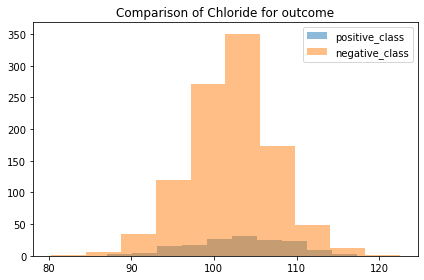

Chloride
 Ttest_indResult(statistic=2.053817948870098, pvalue=0.04021439724858192)
Difference is statistically significant at alpha = 0.05


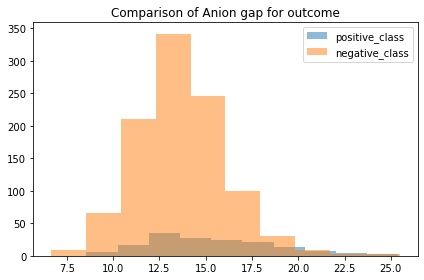

Anion gap
 Ttest_indResult(statistic=8.085696871047555, pvalue=1.5274002718770544e-15)
Difference is statistically significant at alpha = 0.05


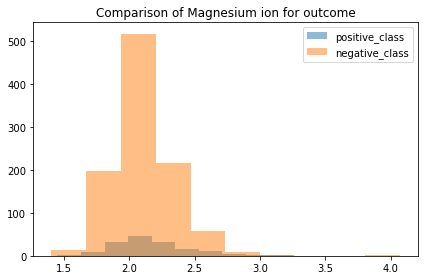

Magnesium ion
 Ttest_indResult(statistic=2.5436327416538327, pvalue=0.011097995425677581)
Difference is statistically significant at alpha = 0.05


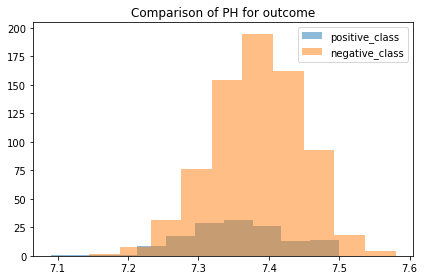

PH
 Ttest_indResult(statistic=-4.527083774415403, pvalue=6.799544642542673e-06)
Difference is statistically significant at alpha = 0.05


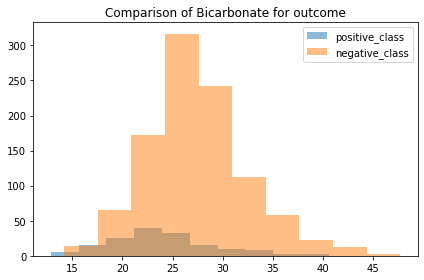

Bicarbonate
 Ttest_indResult(statistic=-7.825245164183045, pvalue=1.1242233591808345e-14)
Difference is statistically significant at alpha = 0.05


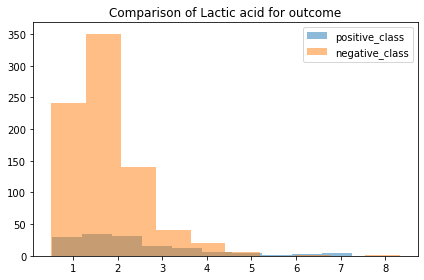

Lactic acid
 Ttest_indResult(statistic=7.258824672316932, pvalue=8.138343939715197e-13)
Difference is statistically significant at alpha = 0.05


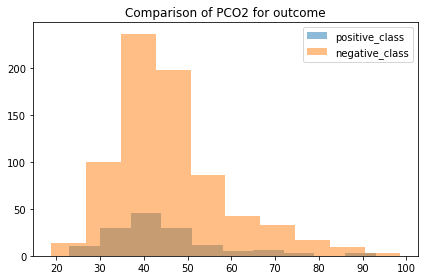

PCO2
 Ttest_indResult(statistic=-1.4715423539348427, pvalue=0.14150159966624917)
Result is not statistically significant at alpha = 0.05


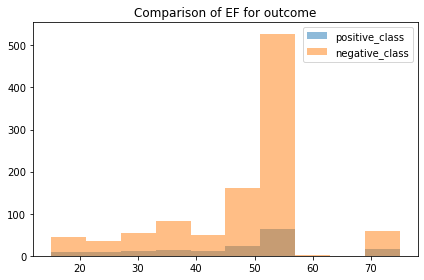

EF
 Ttest_indResult(statistic=-0.8273063527110623, pvalue=0.40823156788785475)
Result is not statistically significant at alpha = 0.05


In [170]:
for feature in continuous_features: 
    compare_features(df, 'outcome', feature, bins=10,save_fig =1)  

Based on the plots and results of the t-tests, the list below will be the candidate continuous features for the model. 

In [171]:
continuous_features = ['Diastolic blood pressure','Respiratory rate','temperature','SP O2','Urine output'
                      ,'RDW', 'Leucocyte', 'Platelets','Neutrophils','Lymphocyte','PT','INR','Blood potassium'
                      , 'Blood sodium', 'Chloride','Blood calcium','Anion gap','Magnesium ion','PH'
                      , 'Lactic acid','age'
                       #,'heart rate'
                      ]

# Discrete Features

We will loop through all the discrete features and proceed with the ones that are statistically significant. 

In [172]:
discrete_features = ['gendera', 'hypertensive'
                     ,'atrialfibrillation', 'CHD with no MI', 'diabetes' 
                     , 'deficiencyanemias','depression', 'Hyperlipemia'
                     , 'Renal failure', 'COPD']

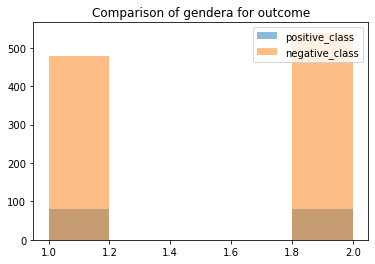

Positive class proportion of gendera is 1.4968553459119496
Negative class proportion of gendera is 1.5299901671583087
Sample size for positive class 159
Sample size for negative class 1017
Critical value is (-2.7420845225816025e-17+0.447816386649726j) compared to 1.959963984540054
Result is not statistically significant at alpha = 0.05


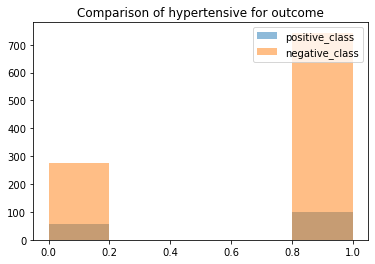

Positive class proportion of hypertensive is 0.6352201257861635
Negative class proportion of hypertensive is 0.7305801376597837
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -2.3469804958134306 compared to 1.959963984540054
Difference is statistically significant at alpha = 0.05


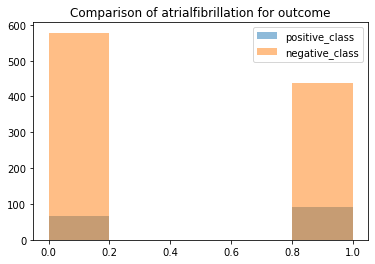

Positive class proportion of atrialfibrillation is 0.5786163522012578
Negative class proportion of atrialfibrillation is 0.43166175024582104
Sample size for positive class 159
Sample size for negative class 1017
Critical value is 3.488370293297704 compared to 1.959963984540054
Difference is statistically significant at alpha = 0.05


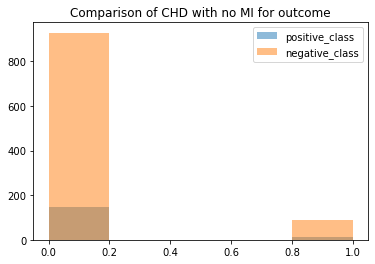

Positive class proportion of CHD with no MI is 0.07547169811320754
Negative class proportion of CHD with no MI is 0.08751229105211406
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -0.5293603608254099 compared to 1.959963984540054
Result is not statistically significant at alpha = 0.05


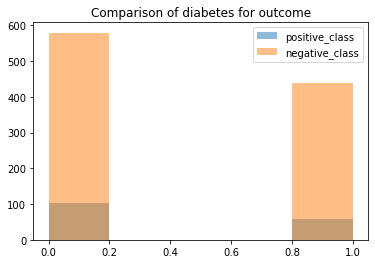

Positive class proportion of diabetes is 0.3584905660377358
Negative class proportion of diabetes is 0.4306784660766962
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -1.757296666436674 compared to 1.959963984540054
Result is not statistically significant at alpha = 0.05


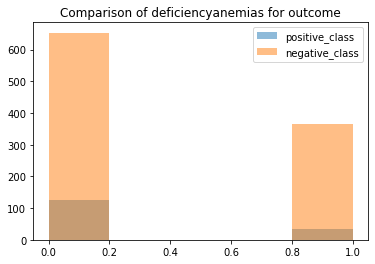

Positive class proportion of deficiencyanemias is 0.22012578616352202
Negative class proportion of deficiencyanemias is 0.3579154375614553
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -3.813307000899952 compared to 1.959963984540054
Difference is statistically significant at alpha = 0.05


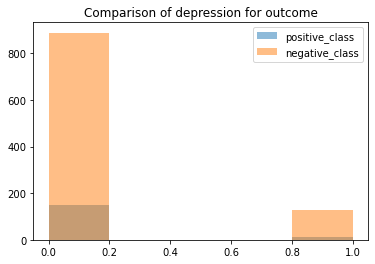

Positive class proportion of depression is 0.06918238993710692
Negative class proportion of depression is 0.12684365781710916
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -2.543551057795873 compared to 1.959963984540054
Difference is statistically significant at alpha = 0.05


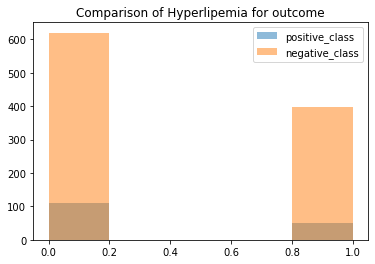

Positive class proportion of Hyperlipemia is 0.31446540880503143
Negative class proportion of Hyperlipemia is 0.39036381514257623
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -1.9035185077922374 compared to 1.959963984540054
Result is not statistically significant at alpha = 0.05


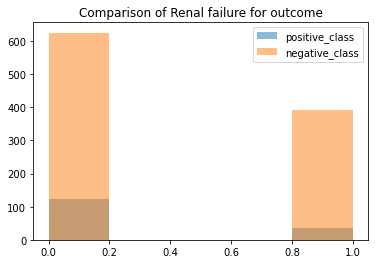

Positive class proportion of Renal failure is 0.23270440251572327
Negative class proportion of Renal failure is 0.3854473942969518
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -4.1480934313440345 compared to 1.959963984540054
Difference is statistically significant at alpha = 0.05


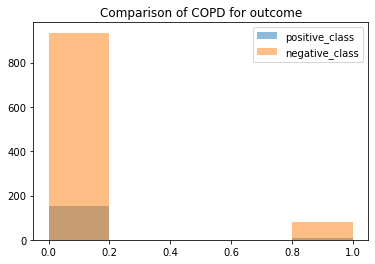

Positive class proportion of COPD is 0.0440251572327044
Negative class proportion of COPD is 0.08062930186823992
Sample size for positive class 159
Sample size for negative class 1017
Critical value is -1.9922209291157962 compared to 1.959963984540054
Difference is statistically significant at alpha = 0.05


In [173]:
for feature in discrete_features: 
    compare_features_prop(df, 'outcome', feature, bins=5)
    

In [174]:
discrete_features = ['hypertensive','atrialfibrillation'
                     ,'deficiencyanemias', 
                    'depression','Renal failure','COPD']

# Modeling

* check for collinearity 
* consider interaction terms

In [175]:
all_features = discrete_features + continuous_features
all_features_with_outcome = discrete_features + continuous_features + ['outcome']

In [176]:
all_features

['hypertensive',
 'atrialfibrillation',
 'deficiencyanemias',
 'depression',
 'Renal failure',
 'COPD',
 'Diastolic blood pressure',
 'Respiratory rate',
 'temperature',
 'SP O2',
 'Urine output',
 'RDW',
 'Leucocyte',
 'Platelets',
 'Neutrophils',
 'Lymphocyte',
 'PT',
 'INR',
 'Blood potassium',
 'Blood sodium',
 'Chloride',
 'Blood calcium',
 'Anion gap',
 'Magnesium ion',
 'PH',
 'Lactic acid',
 'age']

# Model Data Frame with Subset of Featuers

In [177]:
model_df = df[all_features_with_outcome]

# Inspect for nulls + imputation

Now that we have our set of candidate features, we will address the nulls that we looked into previously. 

<AxesSubplot:>

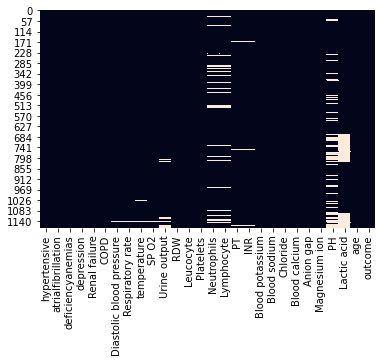

In [178]:
sns.heatmap(model_df.isnull(), cbar=False)

This plot is useful to understand both the volume and distribution of null values. Lactic acid looks like it is missing for certain chunks of the data, whereas Neutrophils and PH are mostly uniform distributed. 

In [179]:
model_df.isna().sum()

hypertensive                  0
atrialfibrillation            0
deficiencyanemias             0
depression                    0
Renal failure                 0
COPD                          0
Diastolic blood pressure     15
Respiratory rate             12
temperature                  18
SP O2                        12
Urine output                 35
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Lymphocyte                  145
PT                           20
INR                          20
Blood potassium               0
Blood sodium                  0
Chloride                      0
Blood calcium                 1
Anion gap                     0
Magnesium ion                 0
PH                          291
Lactic acid                 228
age                           0
outcome                       0
dtype: int64

In [180]:
# Impute means for columns with missing values 
for feature in continuous_features: 
    model_df = impute_mean(model_df,feature)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Now that we have imputed each column with it's mean, we see below there are no nulls remaining in the data set. None of the discrete features had null values, so we did not need to address those. 

In [181]:
model_df.isna().sum()

hypertensive                0
atrialfibrillation          0
deficiencyanemias           0
depression                  0
Renal failure               0
COPD                        0
Diastolic blood pressure    0
Respiratory rate            0
temperature                 0
SP O2                       0
Urine output                0
RDW                         0
Leucocyte                   0
Platelets                   0
Neutrophils                 0
Lymphocyte                  0
PT                          0
INR                         0
Blood potassium             0
Blood sodium                0
Chloride                    0
Blood calcium               0
Anion gap                   0
Magnesium ion               0
PH                          0
Lactic acid                 0
age                         0
outcome                     0
dtype: int64

# Test train Split

Now on to modeling! First, we need to split the data frame into train, validation, and test sets and then standardize each continuous feature. 

The splits are:  20% test, 16% validation, 64% train 

In [182]:
X_train_interim, X_test, y_train_interim, y_test = train_test_split(model_df[all_features],model_df['outcome'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_interim, y_train_interim, test_size=0.20, random_state=1) 

# reset indices 
X_test = X_test.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

## For continous variables: Apply z standardization

In [183]:
for feature in continuous_features: 
    print(feature)
    X_train, X_test, X_val = z_standardize_variable(X_train, X_test, X_val,feature,drop_original='drop')

Diastolic blood pressure
Respiratory rate
temperature
SP O2
Urine output
RDW
Leucocyte
Platelets
Neutrophils
Lymphocyte
PT
INR
Blood potassium
Blood sodium
Chloride
Blood calcium
Anion gap
Magnesium ion
PH
Lactic acid
age


In [184]:
X_train.columns

Index(['hypertensive', 'atrialfibrillation', 'deficiencyanemias', 'depression',
       'Renal failure', 'COPD', 'Diastolic blood pressure_standardized',
       'Respiratory rate_standardized', 'temperature_standardized',
       'SP O2_standardized', 'Urine output_standardized', 'RDW_standardized',
       'Leucocyte_standardized', 'Platelets_standardized',
       'Neutrophils_standardized', 'Lymphocyte_standardized',
       'PT_standardized', 'INR_standardized', 'Blood potassium_standardized',
       'Blood sodium_standardized', 'Chloride_standardized',
       'Blood calcium_standardized', 'Anion gap_standardized',
       'Magnesium ion_standardized', 'PH_standardized',
       'Lactic acid_standardized', 'age_standardized'],
      dtype='object')

# Now we have a processed model friendly training, test, and validation sets! 

# Logistic Regression

In [238]:
features

['hypertensive',
 'atrialfibrillation',
 'deficiencyanemias',
 'depression',
 'Renal failure',
 'COPD',
 'Diastolic blood pressure_standardized',
 'Respiratory rate_standardized',
 'temperature_standardized',
 'SP O2_standardized',
 'Urine output_standardized',
 'RDW_standardized',
 'Leucocyte_standardized',
 'Platelets_standardized',
 'Lymphocyte_standardized',
 'INR_standardized',
 'Blood potassium_standardized',
 'Blood sodium_standardized',
 'Chloride_standardized',
 'Blood calcium_standardized',
 'Anion gap_standardized',
 'Magnesium ion_standardized',
 'PH_standardized',
 'Lactic acid_standardized',
 'age_standardized']

In [185]:
features = [ 'hypertensive', 
             'atrialfibrillation',
             'deficiencyanemias', 
             'depression', 
             'Renal failure', 
             'COPD', 
             'Diastolic blood pressure_standardized', 
             'Respiratory rate_standardized',
             'temperature_standardized', 
             'SP O2_standardized', 
             'Urine output_standardized', 
             'RDW_standardized',
             'Leucocyte_standardized', 
             'Platelets_standardized',
           #  'Neutrophils_standardized',  # removed because of high VIF
             'Lymphocyte_standardized', 
         #    'PT_standardized',  #removed because of high VIF
             'INR_standardized', 
             'Blood potassium_standardized',
             'Blood sodium_standardized',
             'Chloride_standardized', 
             'Blood calcium_standardized', 
             'Anion gap_standardized',
             'Magnesium ion_standardized', 
             'PH_standardized',
             'Lactic acid_standardized',
             'age_standardized']

In [186]:
X_train = X_train[features]

Training Set
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94       648
         1.0       0.80      0.36      0.49       104

    accuracy                           0.90       752
   macro avg       0.85      0.67      0.72       752
weighted avg       0.89      0.90      0.88       752



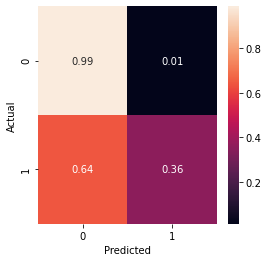

ROC AUC Score is 0.8624762583095916


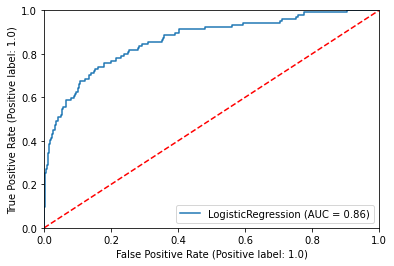

Validation Set
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       160
         1.0       0.53      0.36      0.43        28

    accuracy                           0.86       188
   macro avg       0.71      0.65      0.67       188
weighted avg       0.84      0.86      0.84       188



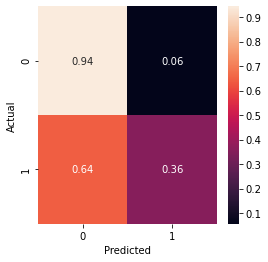

ROC AUC Score is 0.7078125


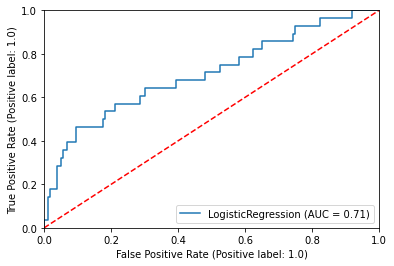

Test Set
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       209
         1.0       0.47      0.26      0.33        27

    accuracy                           0.88       236
   macro avg       0.69      0.61      0.63       236
weighted avg       0.86      0.88      0.87       236



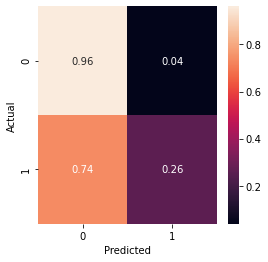

ROC AUC Score is 0.7793726741095162


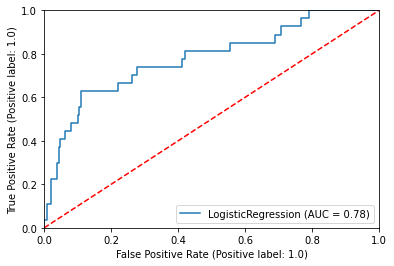

In [187]:
X_train = X_train[features]

logmodel = LogisticRegression() 
logmodel.fit(X_train, y_train)

print("Training Set")
results_dict['logistic_regression_training'] = evaluate_model(logmodel, X_train[features], y_train)

print("Validation Set")
results_dict['logistic_regression_validation'] = evaluate_model(logmodel, X_val[features], y_val)

print("Test Set")
results_dict['logistic_regression_test'] = evaluate_model(logmodel, X_test[features], y_test)

# Random Forest 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



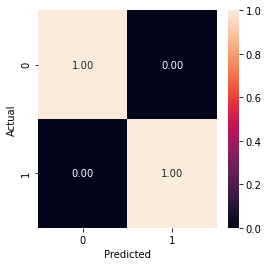

ROC AUC Score is 1.0


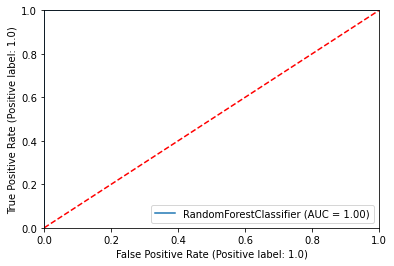

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       160
         1.0       0.50      0.14      0.22        28

    accuracy                           0.85       188
   macro avg       0.68      0.56      0.57       188
weighted avg       0.81      0.85      0.81       188



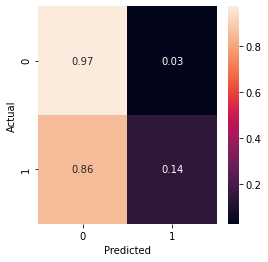

ROC AUC Score is 0.7474330357142858


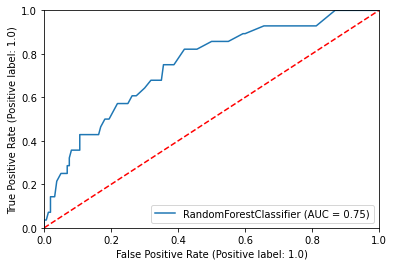

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94       209
         1.0       0.67      0.22      0.33        27

    accuracy                           0.90       236
   macro avg       0.79      0.60      0.64       236
weighted avg       0.88      0.90      0.87       236



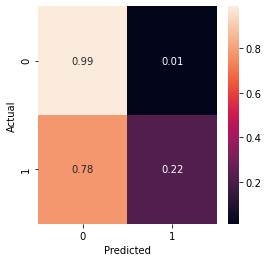

ROC AUC Score is 0.7856636540847066


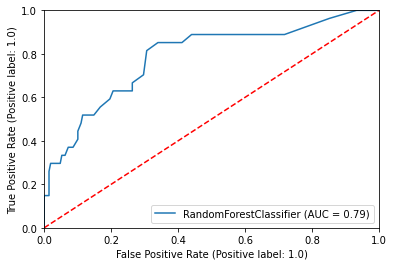

In [188]:
label = 'random_forest'
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
results_dict[f'{label}_training'] = evaluate_model(clf, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(clf, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(clf, X_test[features], y_test)

Text(0, 0.5, 'Mean decrease in impurity')

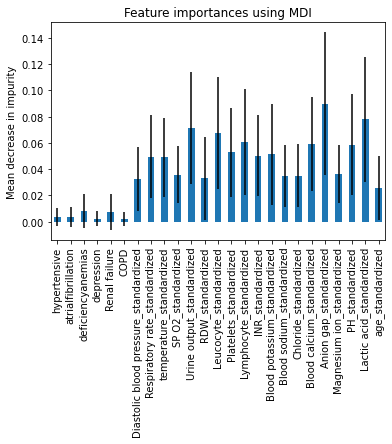

In [189]:
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# XGBoost

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:45:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



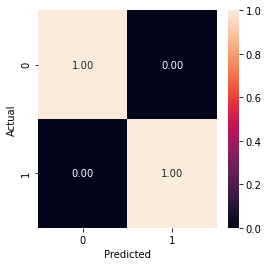

ROC AUC Score is 1.0


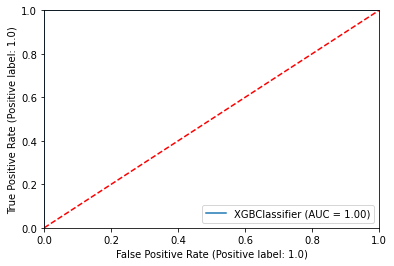

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91       160
         1.0       0.42      0.29      0.34        28

    accuracy                           0.84       188
   macro avg       0.65      0.61      0.62       188
weighted avg       0.81      0.84      0.82       188



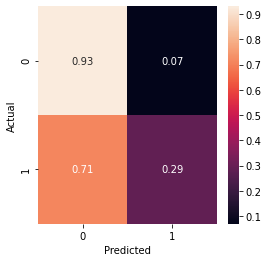

ROC AUC Score is 0.7430803571428571


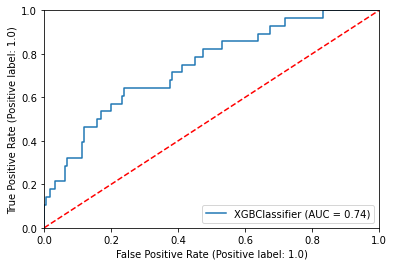

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       209
         1.0       0.40      0.22      0.29        27

    accuracy                           0.87       236
   macro avg       0.65      0.59      0.61       236
weighted avg       0.85      0.87      0.86       236



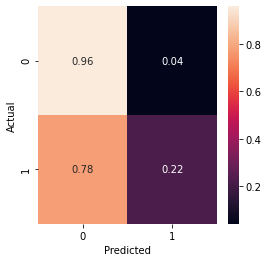

ROC AUC Score is 0.736842105263158


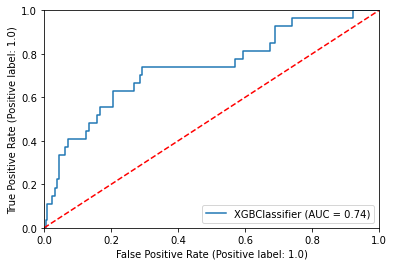

In [190]:
label = 'xgboost'
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
results_dict[f'{label}_training'] = evaluate_model(xgb, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(xgb, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(xgb, X_test[features], y_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

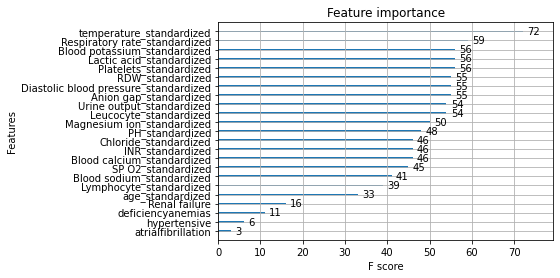

In [191]:
plot_importance(xgb)

# Imbalanced Class (Try SMOTE)

In [192]:
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       648
         1.0       0.40      0.69      0.50       104

    accuracy                           0.81       752
   macro avg       0.67      0.76      0.69       752
weighted avg       0.87      0.81      0.83       752



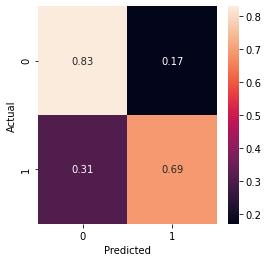

ROC AUC Score is 0.8402629392212726


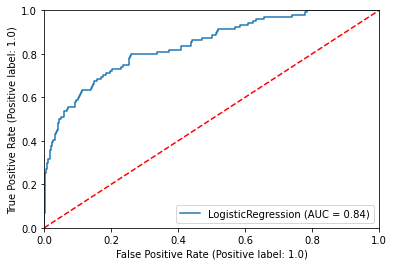

              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       160
         1.0       0.33      0.46      0.38        28

    accuracy                           0.78       188
   macro avg       0.61      0.65      0.62       188
weighted avg       0.81      0.78      0.79       188



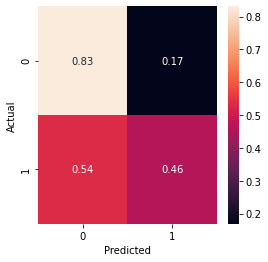

ROC AUC Score is 0.7421875


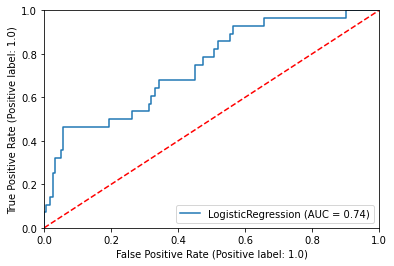

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       209
         1.0       0.35      0.70      0.47        27

    accuracy                           0.82       236
   macro avg       0.65      0.77      0.68       236
weighted avg       0.89      0.82      0.84       236



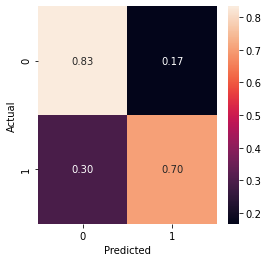

ROC AUC Score is 0.7882332092858408


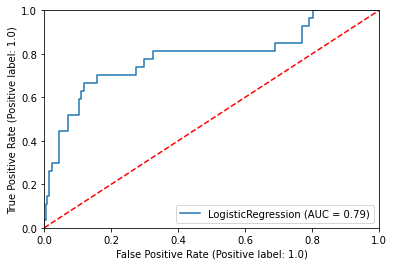

In [193]:
label = 'logistic_regression_SMOTE'
logmodel_smote = LogisticRegression() 
logmodel.fit(X_train_sm[features], y_train_sm)

results_dict[f'{label}_training'] = evaluate_model(logmodel, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(logmodel, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(logmodel, X_test[features], y_test)

# Random Forest with SMOTE

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



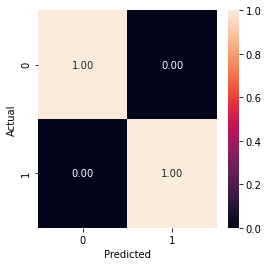

ROC AUC Score is 1.0


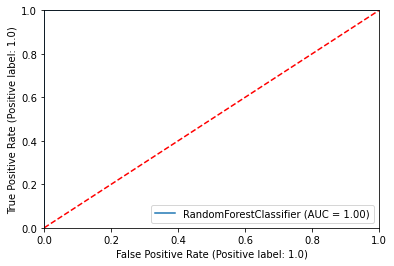

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       160
         1.0       0.50      0.39      0.44        28

    accuracy                           0.85       188
   macro avg       0.70      0.66      0.68       188
weighted avg       0.84      0.85      0.84       188



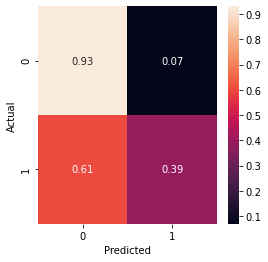

ROC AUC Score is 0.7727678571428571


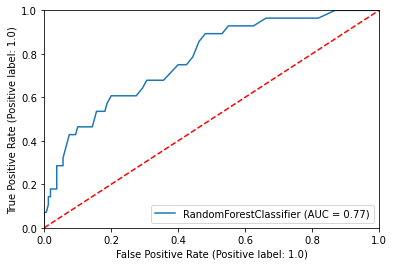

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       209
         1.0       0.35      0.33      0.34        27

    accuracy                           0.85       236
   macro avg       0.63      0.63      0.63       236
weighted avg       0.85      0.85      0.85       236



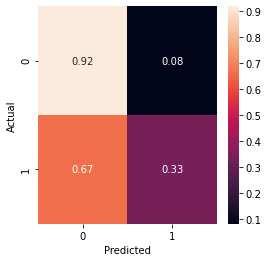

ROC AUC Score is 0.7799043062200957


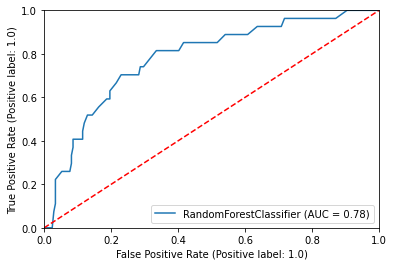

In [194]:
label = 'random_forest_SMOTE'
clf = RandomForestClassifier()
clf.fit(X_train_sm, y_train_sm)
results_dict[f'{label}_training'] = evaluate_model(clf, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(clf, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(clf, X_test[features], y_test)

# XgBoost with SMOTE 

[09:45:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



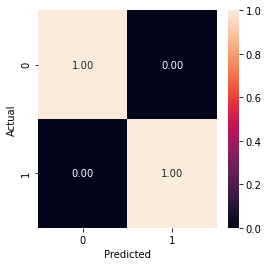

ROC AUC Score is 1.0


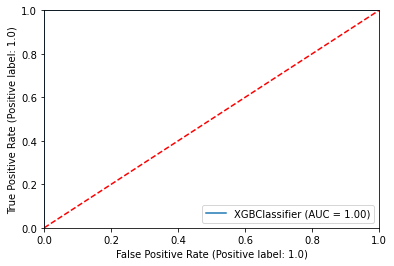

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       160
         1.0       0.46      0.43      0.44        28

    accuracy                           0.84       188
   macro avg       0.68      0.67      0.68       188
weighted avg       0.84      0.84      0.84       188



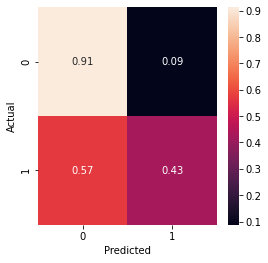

ROC AUC Score is 0.79375


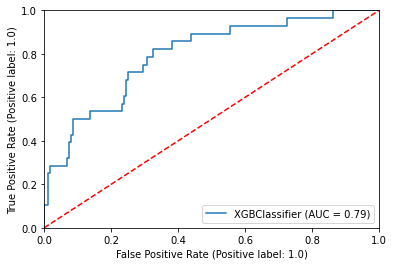

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       209
         1.0       0.36      0.37      0.36        27

    accuracy                           0.85       236
   macro avg       0.64      0.64      0.64       236
weighted avg       0.85      0.85      0.85       236



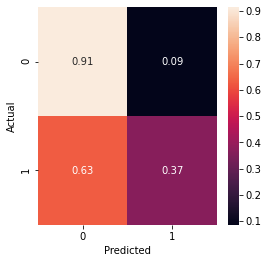

ROC AUC Score is 0.7738791423001949


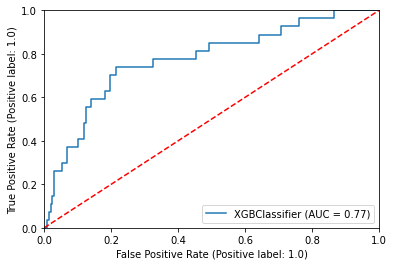

In [195]:
label = 'xgboost_SMOTE'
xgb = XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)
results_dict[f'{label}_training'] = evaluate_model(xgb, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(xgb, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(xgb, X_test[features], y_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

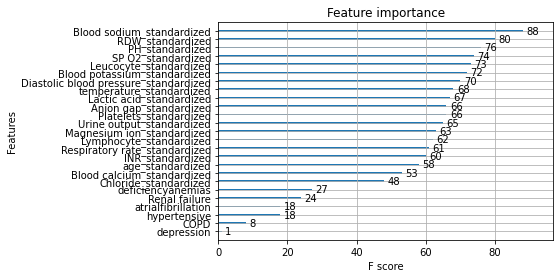

In [196]:
plot_importance(xgb)

# Support Vector Machine (With and without SMOTE)

### Without SMOTE

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       648
         1.0       0.98      0.49      0.65       104

    accuracy                           0.93       752
   macro avg       0.95      0.74      0.81       752
weighted avg       0.93      0.93      0.92       752



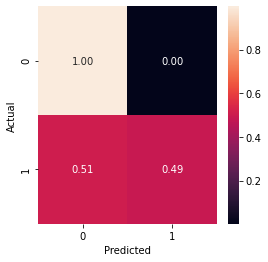

ROC AUC Score is 0.9748486467236467


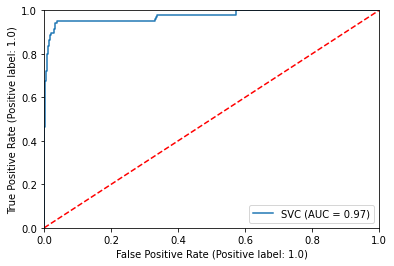

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92       160
         1.0       0.60      0.21      0.32        28

    accuracy                           0.86       188
   macro avg       0.74      0.59      0.62       188
weighted avg       0.84      0.86      0.83       188



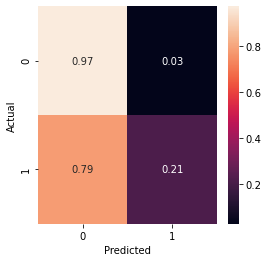

ROC AUC Score is 0.7620535714285714


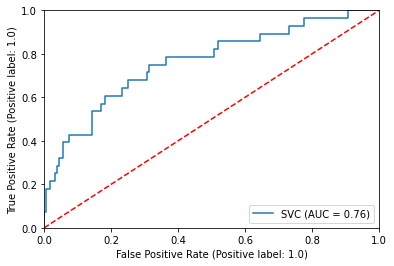

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       209
         1.0       0.60      0.11      0.19        27

    accuracy                           0.89       236
   macro avg       0.75      0.55      0.56       236
weighted avg       0.86      0.89      0.85       236



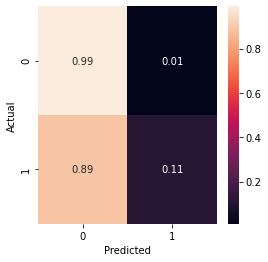

ROC AUC Score is 0.7449937976253767


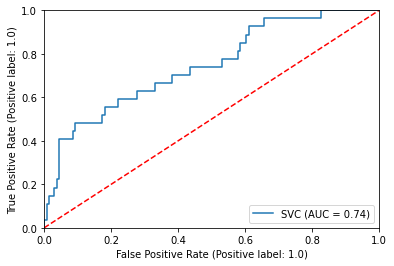

In [197]:
label = 'SVM'
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train, y_train)
results_dict[f'{label}_training'] = evaluate_model(svm_model, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(svm_model, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(svm_model, X_test[features], y_test)

# Support Vector Machine With SMOTE

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       648
         1.0       0.80      0.97      0.87       104

    accuracy                           0.96       752
   macro avg       0.90      0.97      0.93       752
weighted avg       0.97      0.96      0.96       752



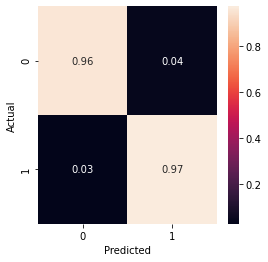

ROC AUC Score is 0.9923136277302944


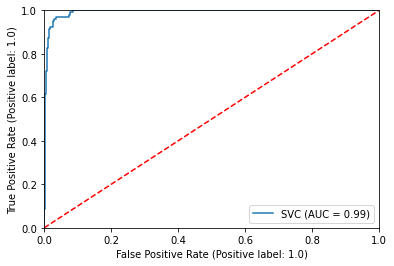

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       160
         1.0       0.50      0.46      0.48        28

    accuracy                           0.85       188
   macro avg       0.70      0.69      0.70       188
weighted avg       0.85      0.85      0.85       188



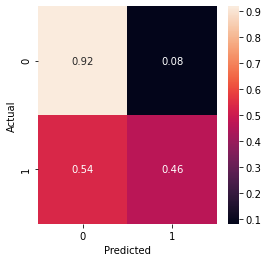

ROC AUC Score is 0.7656249999999999


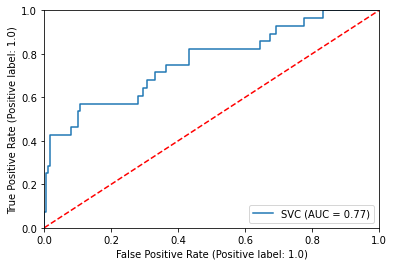

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       209
         1.0       0.32      0.37      0.34        27

    accuracy                           0.84       236
   macro avg       0.62      0.63      0.63       236
weighted avg       0.85      0.84      0.84       236



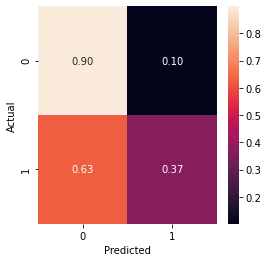

ROC AUC Score is 0.7572213361687046


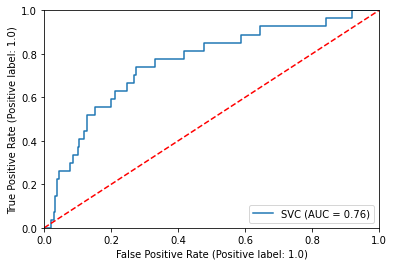

In [230]:
label = 'SVM_SMOTE'
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train_sm, y_train_sm)
results_dict[f'{label}_training'] = evaluate_model(svm_model, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(svm_model, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(svm_model, X_test[features], y_test)

# Multi Layer Perceptron no SMOTE

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



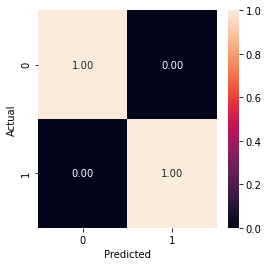

ROC AUC Score is 1.0


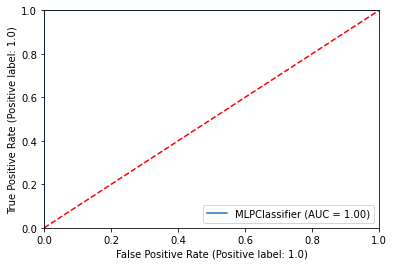

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       160
         1.0       0.59      0.46      0.52        28

    accuracy                           0.87       188
   macro avg       0.75      0.70      0.72       188
weighted avg       0.86      0.87      0.87       188



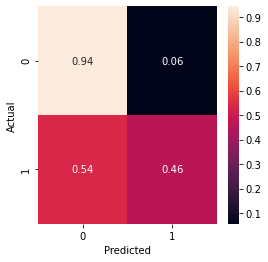

ROC AUC Score is 0.7350446428571429


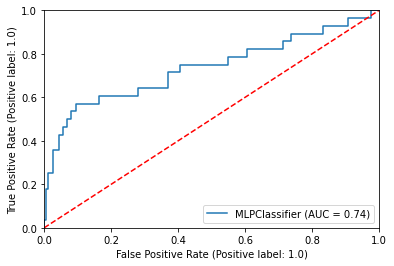

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       209
         1.0       0.40      0.30      0.34        27

    accuracy                           0.87       236
   macro avg       0.66      0.62      0.63       236
weighted avg       0.85      0.87      0.86       236



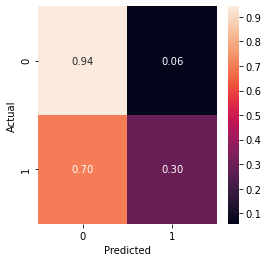

ROC AUC Score is 0.7572213361687046


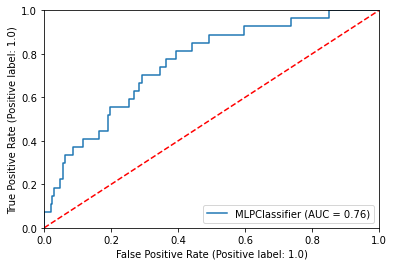

In [199]:
label = 'MLP'
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
classifier.fit(X_train, y_train)
results_dict[f'{label}_training'] = evaluate_model(classifier, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(classifier, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(classifier, X_test[features], y_test)

# Multi Layer Perceptron SMOTE

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



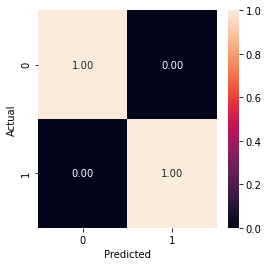

ROC AUC Score is 1.0


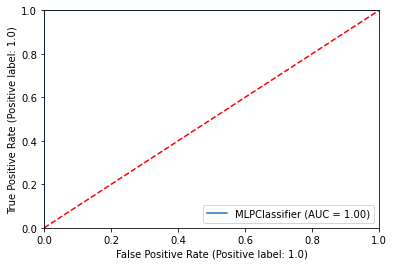

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       160
         1.0       0.57      0.46      0.51        28

    accuracy                           0.87       188
   macro avg       0.74      0.70      0.72       188
weighted avg       0.86      0.87      0.86       188



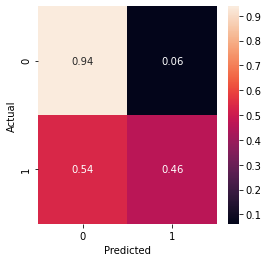

ROC AUC Score is 0.7372767857142857


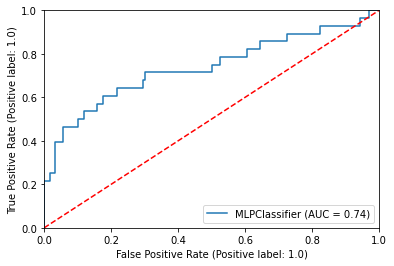

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       209
         1.0       0.48      0.44      0.46        27

    accuracy                           0.88       236
   macro avg       0.70      0.69      0.70       236
weighted avg       0.88      0.88      0.88       236



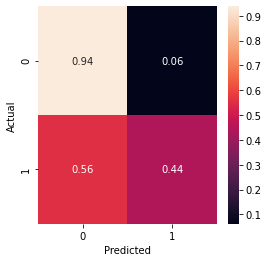

ROC AUC Score is 0.7800815169236223


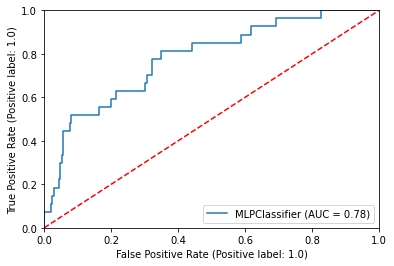

In [200]:
label = 'MLP_SMOTE'
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
classifier.fit(X_train_sm, y_train_sm)
results_dict[f'{label}_training'] = evaluate_model(classifier, X_train[features], y_train)
results_dict[f'{label}_validation'] = evaluate_model(classifier, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(classifier, X_test[features], y_test)

# Apply PCA 

In [201]:
X_train[features].head().T

,0,1,2,3,4
hypertensive,0.000000,1.000000,1.000000,1.000000,1.000000
atrialfibrillation,0.000000,1.000000,1.000000,0.000000,1.000000
deficiencyanemias,0.000000,0.000000,0.000000,1.000000,0.000000
depression,0.000000,0.000000,0.000000,1.000000,0.000000
Renal failure,0.000000,0.000000,0.000000,0.000000,1.000000
COPD,0.000000,0.000000,1.000000,0.000000,0.000000
Diastolic blood pressure_standardized,-0.151710,0.633053,-0.588038,-1.926492,-1.261182
Respiratory rate_standardized,0.514193,-1.038187,2.038379,0.009952,-0.319017
temperature_standardized,0.912374,0.364188,-0.162973,-0.649582,0.406026
SP O2_standardized,0.160547,0.178626,-1.401412,0.240895,0.305173


In [202]:
X_train[features].shape

(752, 25)

In [203]:
X_train.shape

(752, 25)

Text(0.5, 1.0, 'Reconstruction Error vs. Number of Components')

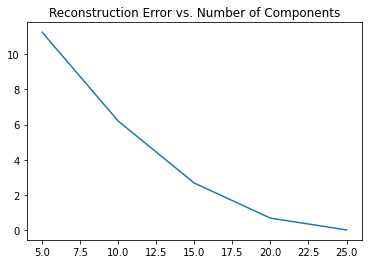

In [204]:
e_dict = {}
component_list = [5,10,15,20,25]

# loop through different number of principal components
for component in component_list: 
    pca = PCA(n_components=component)
    X_train_pca = pca.fit_transform(X_train)
    X_projected = pca.inverse_transform(X_train_pca)
    e_dict[component] = np.sum((X_train - X_projected) ** 2, axis=1).mean() 
    
# construct data frame 
error_df = pd.DataFrame.from_dict(e_dict,orient='index',columns=['reconstruction_error']).reset_index()

# plot vs. reconstruction error 
plt.plot(error_df['index'],error_df['reconstruction_error'])
plt.title("Reconstruction Error vs. Number of Components")

In [237]:
features

['hypertensive',
 'atrialfibrillation',
 'deficiencyanemias',
 'depression',
 'Renal failure',
 'COPD',
 'Diastolic blood pressure_standardized',
 'Respiratory rate_standardized',
 'temperature_standardized',
 'SP O2_standardized',
 'Urine output_standardized',
 'RDW_standardized',
 'Leucocyte_standardized',
 'Platelets_standardized',
 'Lymphocyte_standardized',
 'INR_standardized',
 'Blood potassium_standardized',
 'Blood sodium_standardized',
 'Chloride_standardized',
 'Blood calcium_standardized',
 'Anion gap_standardized',
 'Magnesium ion_standardized',
 'PH_standardized',
 'Lactic acid_standardized',
 'age_standardized']

Looks like n = 20 components is a good fit. 

# PCA n = 20 components

In [205]:
component=20
pca = PCA(n_components=component)
X_train_pca = pca.fit_transform(X_train[features])
X_test_pca = pca.transform(X_test[features])
X_val_pca = pca.transform(X_val[features])

# Logistic Regression with PCA

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       648
         1.0       0.77      0.35      0.48       104

    accuracy                           0.89       752
   macro avg       0.83      0.66      0.71       752
weighted avg       0.88      0.89      0.88       752



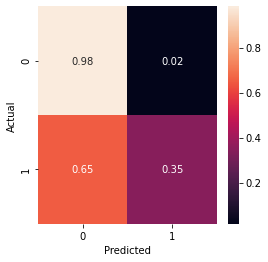

ROC AUC Score is 0.8603395061728396


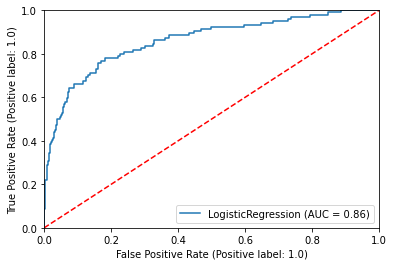

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92       160
         1.0       0.50      0.29      0.36        28

    accuracy                           0.85       188
   macro avg       0.69      0.62      0.64       188
weighted avg       0.83      0.85      0.83       188



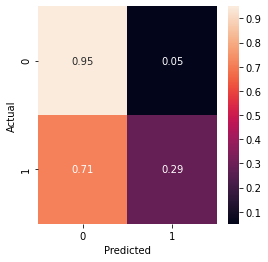

ROC AUC Score is 0.7013392857142857


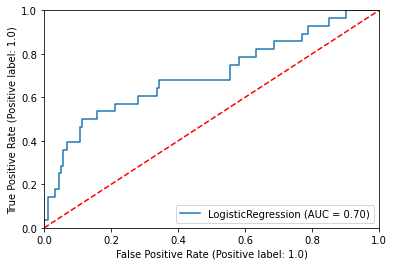

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       209
         1.0       0.46      0.22      0.30        27

    accuracy                           0.88       236
   macro avg       0.68      0.59      0.62       236
weighted avg       0.85      0.88      0.86       236



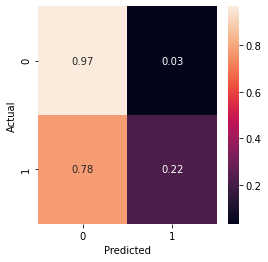

ROC AUC Score is 0.771752613857877


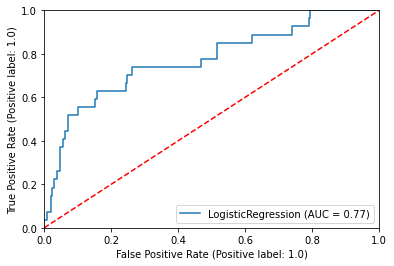

In [206]:
label = 'logistic_regression_PCA'
logmodel_smote = LogisticRegression() 
logmodel.fit(X_train_pca, y_train)
results_dict[f'{label}_training'] = evaluate_model(logmodel, X_train_pca, y_train)
results_dict[f'{label}_validation'] = evaluate_model(logmodel, X_val_pca, y_val)
results_dict[f'{label}_test'] = evaluate_model(logmodel, X_test_pca, y_test)

# Variance Inflation Factor

In [207]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train[features].columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train[features].values, i)
                          for i in range(len(X_train[features].columns))]
  
print(vif_data)

                                  feature       VIF
0                            hypertensive  2.258649
1                      atrialfibrillation  1.758345
2                       deficiencyanemias  1.537197
3                              depression  1.175079
4                           Renal failure  1.918191
5                                    COPD  1.183174
6   Diastolic blood pressure_standardized  1.335061
7           Respiratory rate_standardized  1.144659
8                temperature_standardized  1.191857
9                      SP O2_standardized  1.119029
10              Urine output_standardized  1.234756
11                       RDW_standardized  1.193495
12                 Leucocyte_standardized  1.356855
13                 Platelets_standardized  1.162254
14                Lymphocyte_standardized  1.217588
15                       INR_standardized  1.199630
16           Blood potassium_standardized  1.408925
17              Blood sodium_standardized  2.388773
18          

We see that PT_standardized and INR_standardized have high values for VIF so that means we should only keep one of them. 

# Comparison of Results 

In [208]:
results_dict

{'logistic_regression_training': 0.8624762583095916,
 'logistic_regression_validation': 0.7078125,
 'logistic_regression_test': 0.7793726741095162,
 'random_forest_training': 1.0,
 'random_forest_validation': 0.7474330357142858,
 'random_forest_test': 0.7856636540847066,
 'xgboost_training': 1.0,
 'xgboost_validation': 0.7430803571428571,
 'xgboost_test': 0.736842105263158,
 'logistic_regression_SMOTE_training': 0.8402629392212726,
 'logistic_regression_SMOTE_validation': 0.7421875,
 'logistic_regression_SMOTE_test': 0.7882332092858408,
 'random_forest_SMOTE_training': 1.0,
 'random_forest_SMOTE_validation': 0.7727678571428571,
 'random_forest_SMOTE_test': 0.7799043062200957,
 'xgboost_SMOTE_training': 1.0,
 'xgboost_SMOTE_validation': 0.79375,
 'xgboost_SMOTE_test': 0.7738791423001949,
 'SVM_training': 0.9923136277302944,
 'SVM_validation': 0.7656249999999999,
 'SVM_test': 0.7570441254651781,
 'MLP_training': 1.0,
 'MLP_validation': 0.7350446428571429,
 'MLP_test': 0.7572213361687046,

# Hyper parameter Tuning

To optimize modeel peformance, we will use randomized search to tune each model's hyper parameters using the validation set. 

### Logistic Regression Tuning

In [209]:
model = LogisticRegression() 
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['fit_intercept'] = [True,False]
search = RandomizedSearchCV(model
                           , space
                           , n_iter=12
                           , scoring='roc_auc'
                           , n_jobs=-1
                           , cv=5
                           , random_state=1)
result = search.fit(X_train[features], y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8117699974444161
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'fit_intercept': True}


One or more of the test scores are non-finite: [       nan 0.81177    0.78285947 0.81022864 0.78293273        nan
        nan 0.81177           nan        nan        nan        nan]


### Apply best model to validation set 

Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94       648
         1.0       0.80      0.36      0.49       104

    accuracy                           0.90       752
   macro avg       0.85      0.67      0.72       752
weighted avg       0.89      0.90      0.88       752



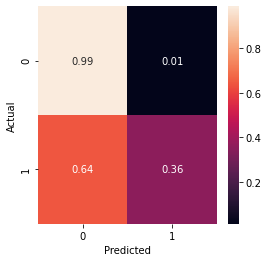

ROC AUC Score is 0.8624910968660969


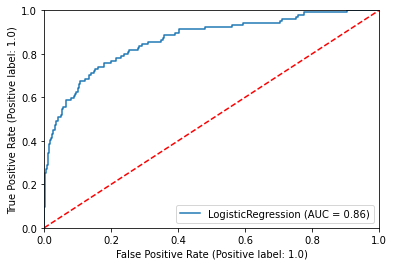

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       160
         1.0       0.53      0.36      0.43        28

    accuracy                           0.86       188
   macro avg       0.71      0.65      0.67       188
weighted avg       0.84      0.86      0.84       188



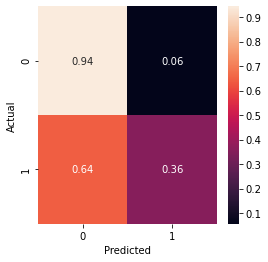

ROC AUC Score is 0.7078125


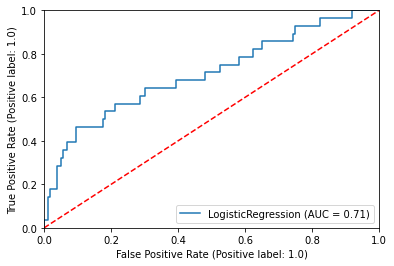

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       209
         1.0       0.47      0.26      0.33        27

    accuracy                           0.88       236
   macro avg       0.69      0.61      0.63       236
weighted avg       0.86      0.88      0.87       236



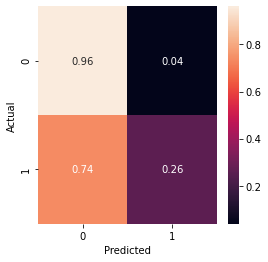

ROC AUC Score is 0.7793726741095162


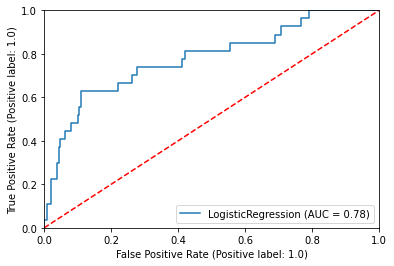

In [210]:
label = 'logistic_regression_tuned'
best_model = LogisticRegression(solver='newton-cg'
                                , penalty='l2'
                                , fit_intercept=True)

best_model.fit(X_train[features],y_train)
print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)
print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)
print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

# Apply best model to SMOTE 

Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83       648
         1.0       0.83      0.84      0.83       648

    accuracy                           0.83      1296
   macro avg       0.83      0.83      0.83      1296
weighted avg       0.83      0.83      0.83      1296



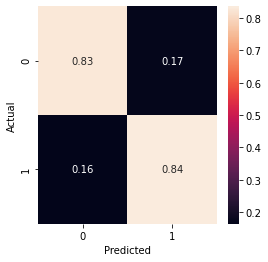

ROC AUC Score is 0.9129705837524766


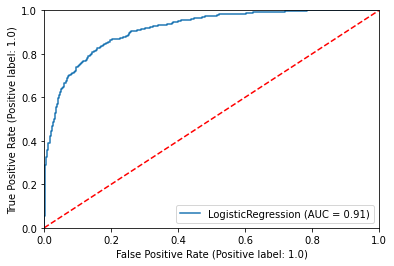

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       160
         1.0       0.33      0.46      0.38        28

    accuracy                           0.78       188
   macro avg       0.61      0.65      0.62       188
weighted avg       0.81      0.78      0.79       188



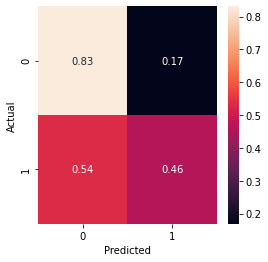

ROC AUC Score is 0.7421875


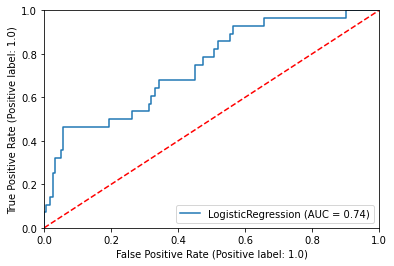

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       209
         1.0       0.35      0.70      0.47        27

    accuracy                           0.82       236
   macro avg       0.65      0.77      0.68       236
weighted avg       0.89      0.82      0.84       236



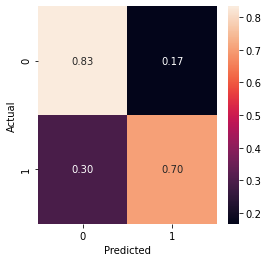

ROC AUC Score is 0.7882332092858408


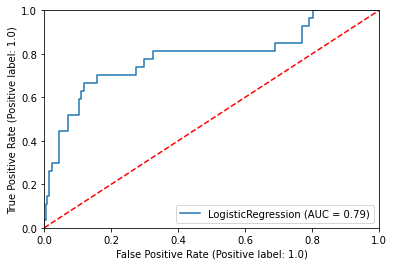

In [234]:
label = 'logistic_regression_tuned_SMOTE'
best_model = LogisticRegression(solver='newton-cg'
                                , penalty='l2'
                                , fit_intercept=True)

best_model.fit(X_train_sm[features],y_train_sm)
print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train_sm[features], y_train_sm)
print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)
print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

### Random Forest Tuning

In [211]:
model = RandomForestClassifier() 
space = dict()
space['max_depth'] = [5,10,15,20,25,30,35,40,50]
space['min_samples_split'] = [10,50,100,500,1000]
space['min_samples_leaf'] = [10,50,100,500,1000]
space['n_estimators'] = [10,50,100,300,500]

search = RandomizedSearchCV(model
                           , space
                           , n_iter=12
                           , scoring='roc_auc'
                           , n_jobs=-1
                           , cv=5
                           , random_state=1)
result = search.fit(X_train[features], y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8360246187920607
Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 50, 'max_depth': 35}


In [212]:
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

### Apply Best Model to Validation Set 

Without SMOTE

Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       648
         1.0       0.00      0.00      0.00       104

    accuracy                           0.86       752
   macro avg       0.43      0.50      0.46       752
weighted avg       0.74      0.86      0.80       752



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


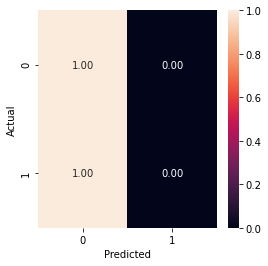

ROC AUC Score is 0.9062054843304843


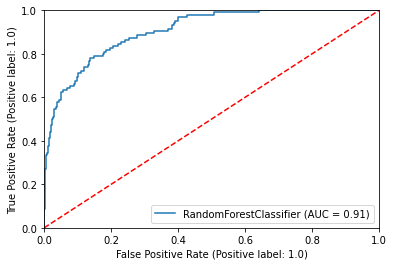

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       160
         1.0       0.00      0.00      0.00        28

    accuracy                           0.85       188
   macro avg       0.43      0.50      0.46       188
weighted avg       0.72      0.85      0.78       188



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


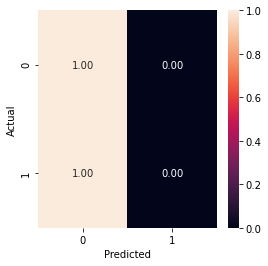

ROC AUC Score is 0.7004464285714286


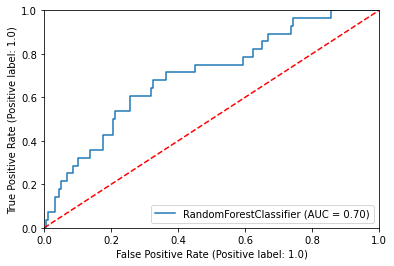

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       209
         1.0       0.00      0.00      0.00        27

    accuracy                           0.89       236
   macro avg       0.44      0.50      0.47       236
weighted avg       0.78      0.89      0.83       236



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


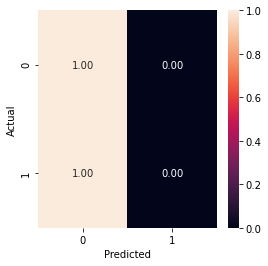

ROC AUC Score is 0.7650186071238704


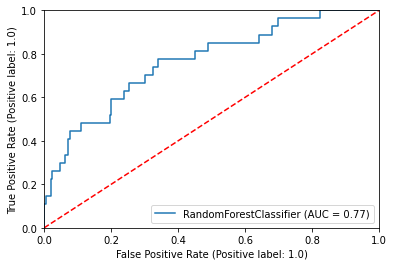

In [213]:
label = 'random_forest_tuned'
best_model = RandomForestClassifier(max_depth=35
                                , min_samples_split=10
                                , min_samples_leaf=50
                                , n_estimators=500)

best_model.fit(X_train[features],y_train)

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

With SMOTE

Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.91       648
         1.0       0.49      0.75      0.60       104

    accuracy                           0.86       752
   macro avg       0.72      0.81      0.76       752
weighted avg       0.89      0.86      0.87       752



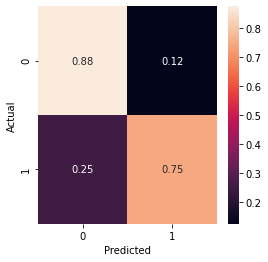

ROC AUC Score is 0.9043358262108261


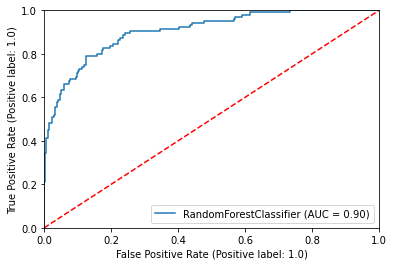

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       160
         1.0       0.32      0.46      0.38        28

    accuracy                           0.77       188
   macro avg       0.61      0.64      0.62       188
weighted avg       0.81      0.77      0.79       188



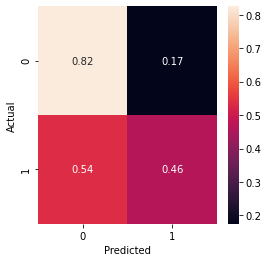

ROC AUC Score is 0.7611607142857143


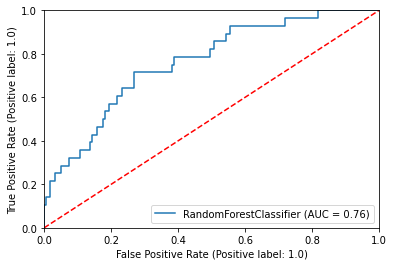

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       209
         1.0       0.30      0.56      0.39        27

    accuracy                           0.80       236
   macro avg       0.62      0.69      0.64       236
weighted avg       0.86      0.80      0.82       236



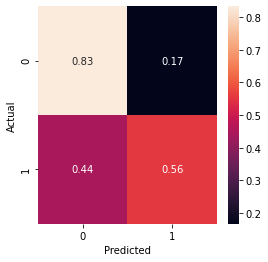

ROC AUC Score is 0.7499556973241184


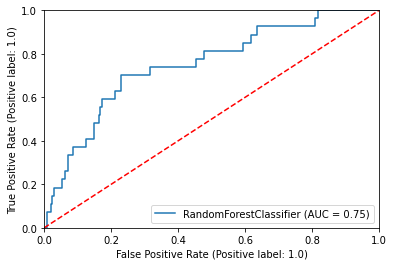

In [214]:
label = 'random_forest_tuned_SMOTE'
best_model = RandomForestClassifier(max_depth=35
                                , min_samples_split=10
                                , min_samples_leaf=50
                                , n_estimators=500)

best_model.fit(X_train_sm[features],y_train_sm)

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

### XGBoost Tuning

In [215]:
model = XGBClassifier()
space = dict()
space['max_depth'] = [5,10,15,20,25,30,35,40,50]
space['eta'] = [0.5,1,2,3,4,5]
space['objective'] = ['binary:logistic']
space['nthread'] = [1,2,3,4,5,6,7,8,9,10]
space['eval_metric'] = ['auc']

search = RandomizedSearchCV(model
                           , space
                           , n_iter=12
                           , scoring='roc_auc'
                           , n_jobs=-1
                           , cv=5
                           , random_state=1)
result = search.fit(X_train[features], y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Best Score: 0.8017238833517902
Best Hyperparameters: {'objective': 'binary:logistic', 'nthread': 6, 'max_depth': 35, 'eval_metric': 'auc', 'eta': 0.5}


### Apply Best Model to Validation and Test Sets with and without SMOTE

Without SMOTE

[0]	validation_0-auc:0.63516
[1]	validation_0-auc:0.66841
[2]	validation_0-auc:0.73047
[3]	validation_0-auc:0.72031
[4]	validation_0-auc:0.72467
[5]	validation_0-auc:0.72757
[6]	validation_0-auc:0.73326
[7]	validation_0-auc:0.74241
[8]	validation_0-auc:0.75558
[9]	validation_0-auc:0.74219
[10]	validation_0-auc:0.73728
[11]	validation_0-auc:0.72723
[12]	validation_0-auc:0.73705
[13]	validation_0-auc:0.73705
[14]	validation_0-auc:0.73438
[15]	validation_0-auc:0.74219
[16]	validation_0-auc:0.74040
[17]	validation_0-auc:0.73973
Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



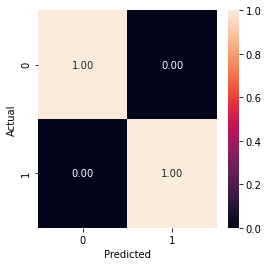

ROC AUC Score is 1.0


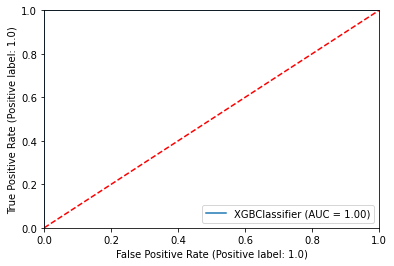

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90       160
         1.0       0.37      0.25      0.30        28

    accuracy                           0.82       188
   macro avg       0.62      0.59      0.60       188
weighted avg       0.80      0.82      0.81       188



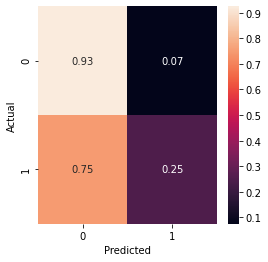

ROC AUC Score is 0.7555803571428571


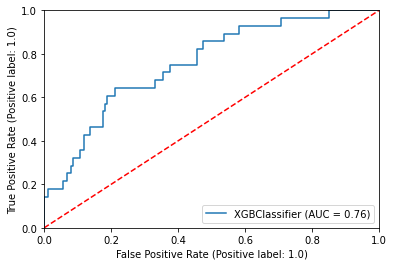

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       209
         1.0       0.33      0.15      0.21        27

    accuracy                           0.87       236
   macro avg       0.62      0.55      0.57       236
weighted avg       0.83      0.87      0.85       236



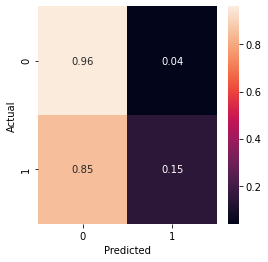

ROC AUC Score is 0.7483608009923799


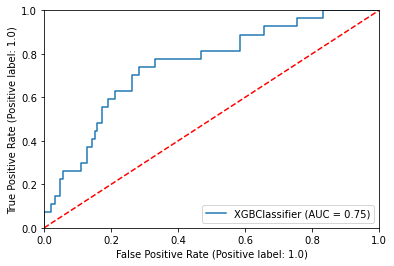

In [216]:
label = 'xgboost_tuned'
eval_set = [(X_val[features], y_val)]
best_model = XGBClassifier(max_depth = 35
                          , eval_metric='auc'
                          , eta=0.5 
                          , nthread=6 
                          , objective= 'binary:logistic'
                        )

best_model.fit(X_train[features]
               ,y_train
               , early_stopping_rounds = 10 
               , eval_set=eval_set 
               , verbose=True)

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

[0]	validation_0-auc:0.68583
[1]	validation_0-auc:0.69163
[2]	validation_0-auc:0.70871
[3]	validation_0-auc:0.69174
[4]	validation_0-auc:0.69018
[5]	validation_0-auc:0.70737
[6]	validation_0-auc:0.71763
[7]	validation_0-auc:0.71674
[8]	validation_0-auc:0.71473
[9]	validation_0-auc:0.70714
[10]	validation_0-auc:0.71138
[11]	validation_0-auc:0.72500
[12]	validation_0-auc:0.73504
[13]	validation_0-auc:0.73147
[14]	validation_0-auc:0.72723
[15]	validation_0-auc:0.73259
[16]	validation_0-auc:0.72500
[17]	validation_0-auc:0.72679
[18]	validation_0-auc:0.72969
[19]	validation_0-auc:0.72879
[20]	validation_0-auc:0.73080
[21]	validation_0-auc:0.73371
[22]	validation_0-auc:0.73393
Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


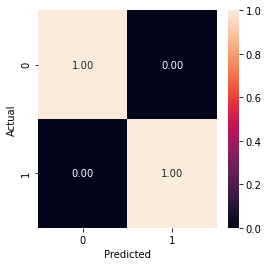

ROC AUC Score is 1.0


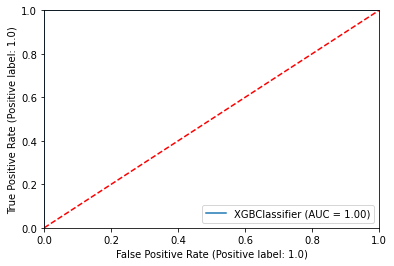

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90       160
         1.0       0.41      0.39      0.40        28

    accuracy                           0.82       188
   macro avg       0.65      0.65      0.65       188
weighted avg       0.82      0.82      0.82       188



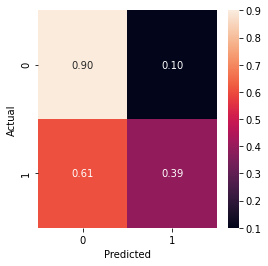

ROC AUC Score is 0.735044642857143


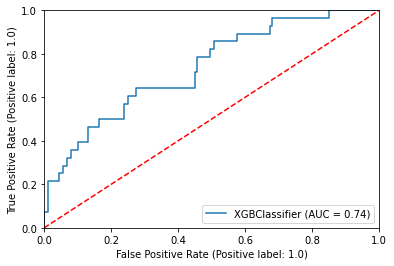

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.89       209
         1.0       0.28      0.37      0.32        27

    accuracy                           0.82       236
   macro avg       0.60      0.62      0.61       236
weighted avg       0.84      0.82      0.83       236



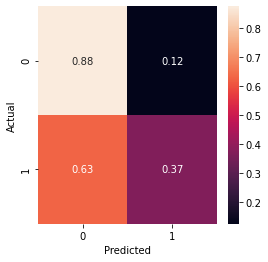

ROC AUC Score is 0.7263866737550947


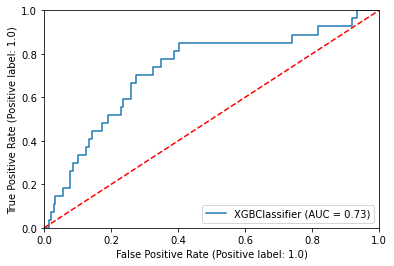

In [217]:
label = 'xgboost_tuned_SMOTE'
eval_set = [(X_val[features], y_val)]
best_model = XGBClassifier(max_depth = 35
                          , eval_metric='auc'
                          , eta=0.5 
                          , nthread=6 
                          , objective= 'binary:logistic'
                        )

best_model.fit(X_train_sm[features]
               ,y_train_sm
               , early_stopping_rounds = 10 
               , eval_set=eval_set 
               , verbose=True)

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

### Support Vector Machine Tuning

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92       160
         1.0       0.60      0.21      0.32        28

    accuracy                           0.86       188
   macro avg       0.74      0.59      0.62       188
weighted avg       0.84      0.86      0.83       188



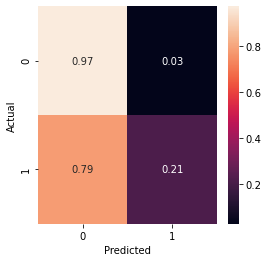

ROC AUC Score is 0.7620535714285714


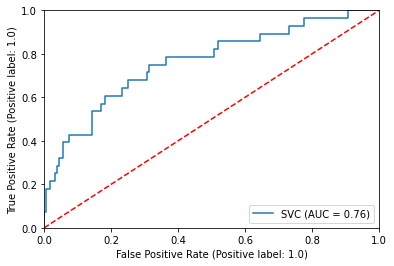

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       209
         1.0       0.60      0.11      0.19        27

    accuracy                           0.89       236
   macro avg       0.75      0.55      0.56       236
weighted avg       0.86      0.89      0.85       236



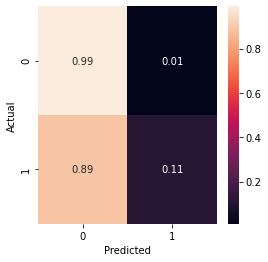

ROC AUC Score is 0.7449937976253767


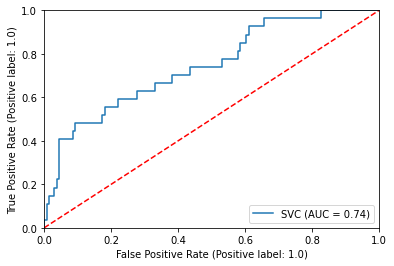

In [218]:
label = 'SVM'
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train, y_train)
results_dict[f'{label}_validation'] = evaluate_model(svm_model, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(svm_model, X_test[features], y_test)

No SMOTE

In [219]:
model = svm.SVC(probability=True)
space = dict()
space['C'] = [0.1,1,10,100]
space['gamma'] = [1,0.1,0.01,0.001]
space['kernel'] = ['rbf','poly','sigmoid']

search = RandomizedSearchCV(model
                           , space
                           , n_iter=12
                           , scoring='roc_auc'
                           , n_jobs=-1
                           , cv=5
                           , random_state=1)
result = search.fit(X_train[features], y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8328795752051565
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}


Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       648
         1.0       0.94      0.16      0.28       104

    accuracy                           0.88       752
   macro avg       0.91      0.58      0.61       752
weighted avg       0.89      0.88      0.85       752



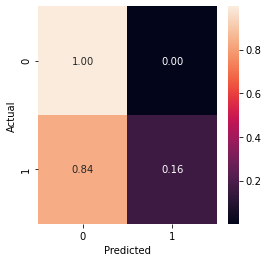

ROC AUC Score is 0.8602578941120609


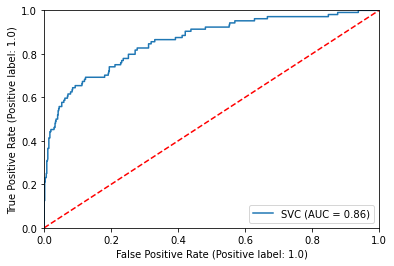

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       160
         1.0       0.57      0.14      0.23        28

    accuracy                           0.86       188
   macro avg       0.72      0.56      0.57       188
weighted avg       0.82      0.86      0.82       188



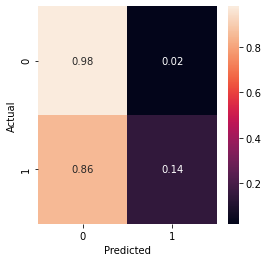

ROC AUC Score is 0.7015625


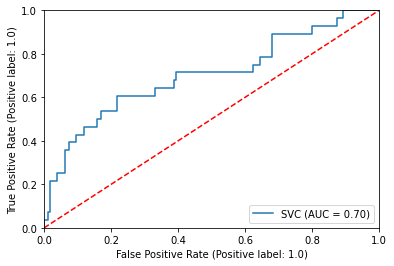

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       209
         1.0       0.50      0.04      0.07        27

    accuracy                           0.89       236
   macro avg       0.69      0.52      0.50       236
weighted avg       0.84      0.89      0.84       236



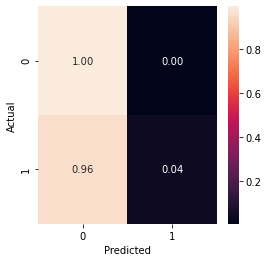

ROC AUC Score is 0.7526138578770157


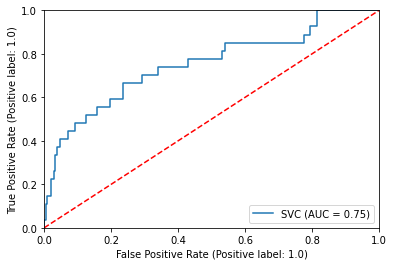

In [220]:
label = 'SVM_tuned'
eval_set = [(X_val[features], y_val)]
best_model = svm.SVC(probability=True
                          , kernel='rbf'
                          , gamma = 0.001
                          , C=10 
                        )

best_model.fit(X_train[features]
               ,y_train
              )

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

With SMOTE

Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88       648
         1.0       0.41      0.76      0.53       104

    accuracy                           0.81       752
   macro avg       0.68      0.79      0.71       752
weighted avg       0.88      0.81      0.83       752



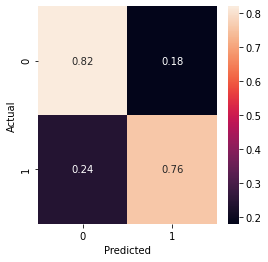

ROC AUC Score is 0.8552943969610636


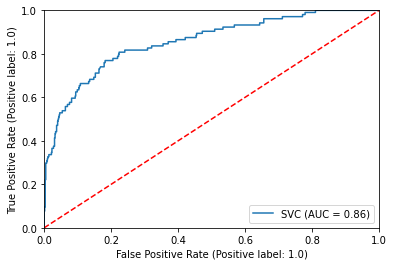

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.84       160
         1.0       0.29      0.46      0.36        28

    accuracy                           0.75       188
   macro avg       0.59      0.63      0.60       188
weighted avg       0.80      0.75      0.77       188



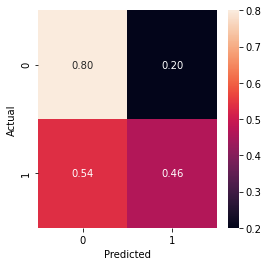

ROC AUC Score is 0.7296875


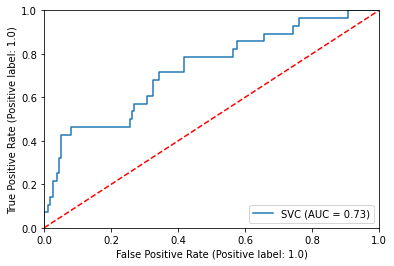

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86       209
         1.0       0.30      0.70      0.42        27

    accuracy                           0.78       236
   macro avg       0.63      0.75      0.64       236
weighted avg       0.88      0.78      0.81       236



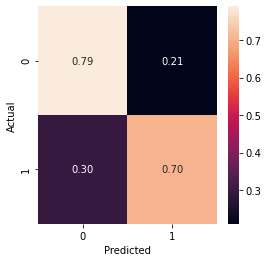

ROC AUC Score is 0.7845117845117845


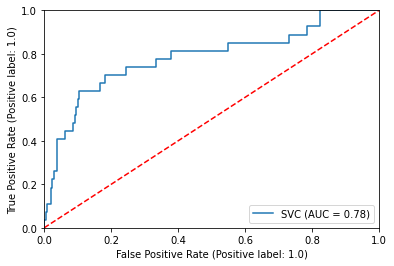

In [221]:
label = 'SVM_tuned_SMOTE'
eval_set = [(X_val[features], y_val)]
best_model = svm.SVC(probability=True
                          , kernel='rbf'
                          , gamma = 0.001
                          , C=10 
                        )

best_model.fit(X_train_sm[features]
               ,y_train_sm
              )

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

### Multi Layer Perceptron Hyper Parameter Tuning

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       160
         1.0       0.59      0.46      0.52        28

    accuracy                           0.87       188
   macro avg       0.75      0.70      0.72       188
weighted avg       0.86      0.87      0.87       188



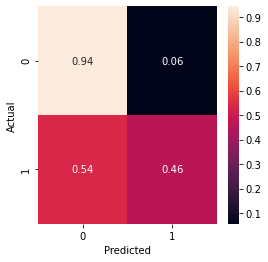

ROC AUC Score is 0.7350446428571429


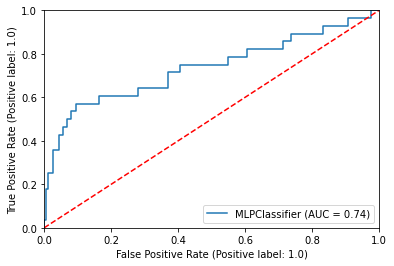

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       209
         1.0       0.40      0.30      0.34        27

    accuracy                           0.87       236
   macro avg       0.66      0.62      0.63       236
weighted avg       0.85      0.87      0.86       236



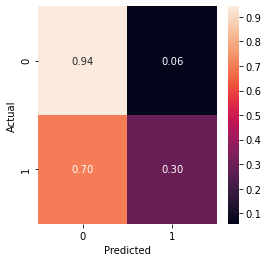

ROC AUC Score is 0.7572213361687046


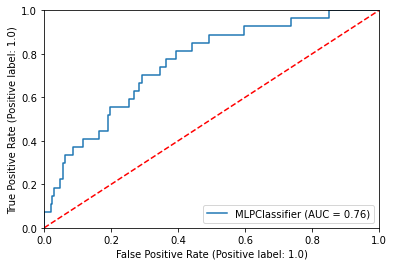

In [222]:
label = 'MLP'
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
classifier.fit(X_train, y_train)
results_dict[f'{label}_validation'] = evaluate_model(classifier, X_val[features], y_val)
results_dict[f'{label}_test'] = evaluate_model(classifier, X_test[features], y_test)

In [223]:
model = MLPClassifier(max_iter=300)
space = dict()
space['hidden_layer_sizes'] = [(50,50,50)
                               , (50,100,50)
                               , (100,)
                               , (50,50,50,50)
                               , (20,20,20,20)
                               , (20,20,20,20,20)
                               , (20,20,20)
                               , (20,)]
space['activation'] = ['tanh','relu']
space['solver'] = ['sgd','adam']
space['alpha'] = [0.0001,0.05,0.01,0.1]
space['learning_rate'] = ['constant','adaptive']

search = RandomizedSearchCV(model
                           , space
                           , n_iter=12
                           , scoring='roc_auc'
                           , n_jobs=-1
                           , cv=5
                           , random_state=1)
result = search.fit(X_train[features], y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8327036374478235
Best Hyperparameters: {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.05, 'activation': 'tanh'}


Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.


Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



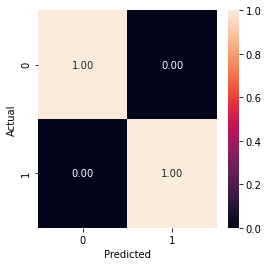

ROC AUC Score is 1.0


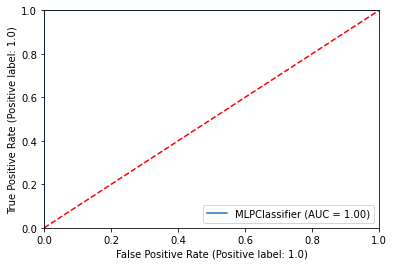

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       160
         1.0       0.40      0.43      0.41        28

    accuracy                           0.82       188
   macro avg       0.65      0.66      0.65       188
weighted avg       0.82      0.82      0.82       188



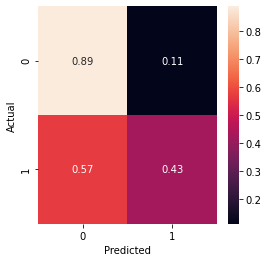

ROC AUC Score is 0.7383928571428572


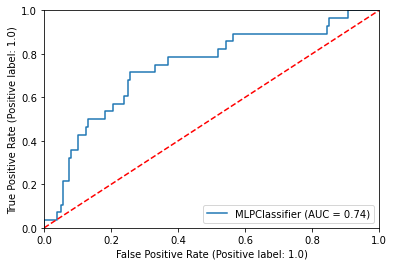

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89       209
         1.0       0.28      0.41      0.33        27

    accuracy                           0.81       236
   macro avg       0.60      0.64      0.61       236
weighted avg       0.85      0.81      0.83       236



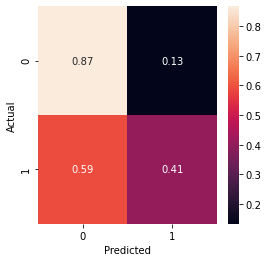

ROC AUC Score is 0.696260854155591


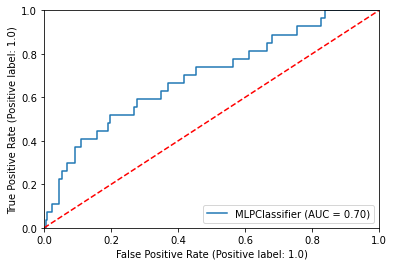

In [224]:
label = 'MLP_tuned'
best_model = MLPClassifier(max_iter=300
                          , solver='adam'
                          , learning_rate = 'adaptive'
                          , hidden_layer_sizes = (20,20,20) 
                          , alpha = 0.0001 
                          , activation = 'tanh')

best_model.fit(X_train[features]
               ,y_train
              )

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

With SMOTE 

Training Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       648
         1.0       1.00      1.00      1.00       104

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



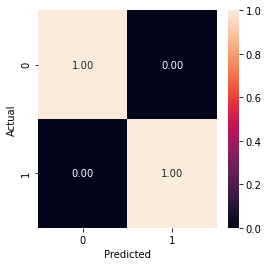

ROC AUC Score is 1.0


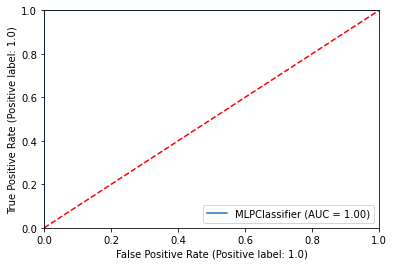

Validation Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       160
         1.0       0.50      0.50      0.50        28

    accuracy                           0.85       188
   macro avg       0.71      0.71      0.71       188
weighted avg       0.85      0.85      0.85       188



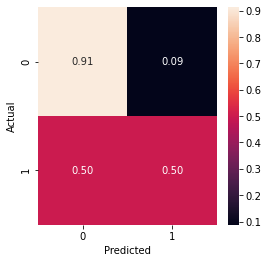

ROC AUC Score is 0.7578125


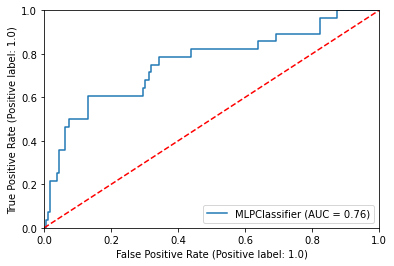

Test Data Set with Best Parameters
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       209
         1.0       0.39      0.44      0.41        27

    accuracy                           0.86       236
   macro avg       0.66      0.68      0.67       236
weighted avg       0.87      0.86      0.86       236



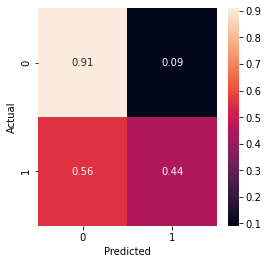

ROC AUC Score is 0.7715754031543506


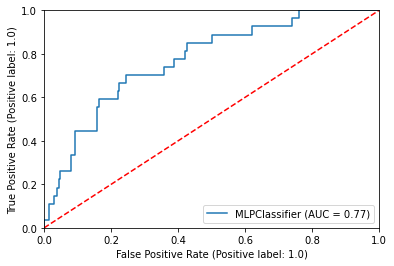

In [225]:
label = 'MLP_tuned_SMOTE'
best_model = MLPClassifier(max_iter=300
                          , solver='adam'
                          , learning_rate = 'adaptive'
                          , hidden_layer_sizes = (20,20,20) 
                          , alpha = 0.0001 
                          , activation = 'tanh')

best_model.fit(X_train_sm[features]
               ,y_train_sm
              )

print("Training Data Set with Best Parameters")
results_dict[f'{label}_train'] = evaluate_model(best_model, X_train[features], y_train)

print("Validation Data Set with Best Parameters")
results_dict[f'{label}_validation'] = evaluate_model(best_model, X_val[features], y_val)

print("Test Data Set with Best Parameters")
results_dict[f'{label}_test'] = evaluate_model(best_model, X_test[features], y_test)

When the ROC-AUC for the training set is 1.0, we know that our model is overfit. 

In [235]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['roc_auc'])

In [227]:
results_df

,roc_auc
logistic_regression_training,0.862476
logistic_regression_validation,0.707812
logistic_regression_test,0.779373
random_forest_training,1.000000
random_forest_validation,0.747433
random_forest_test,0.785664
xgboost_training,1.000000
xgboost_validation,0.743080
xgboost_test,0.736842
logistic_regression_SMOTE_training,0.840263


# Write to CSV 

In [236]:
pd.DataFrame.to_csv(results_df, "heart-failure-prediction-model-results.csv")